### Explain parameters for the code

- Normalize the input data - Κανονικοποιήση

RGB values are typically in the range 0-255. Normalizing them to 0-1 can help the model learn more effectively. Πιο συγκεκριμένα η κανονικοποίηση μπορεί να βοηθήσει το μοντέλο να μάθει πιο γρήγορα, καθώς οι αλγόριθμοι βελτιστοποίησης (όπως η gradient descent) λειτουργούν πιο αποτελεσματικά όταν τα δεδομένα είναι κανονικοποιημένα.H κανονικοποίηση μπορεί να οδηγήσει σε καλύτερη απόδοση του μοντέλου, καθώς βοηθά στην αποφυγή προβλημάτων όπως το "vanishing gradient" (εξαφάνιση κλίσης) ή το "exploding gradient" (έκρηξη κλίσης).Πολλά νευρωνικά δίκτυα χρησιμοποιούν συναρτήσεις ενεργοποίησης όπως η SIGMOID ή tanh, οι οποίες έχουν σχεδιαστεί για να λειτουργούν καλύτερα με εισόδους μεταξύ 0 και 1.

- Encode the target value - Κωδικοποιήση

Machine learning models, especially neural networks, work with numbers, not text. Encoding transforms these text labels into a numerical format the model can understand and process. For multi-class problems, encoded labels allow the use of appropriate loss functions like categorical cross-entropy.

- MLP Model overall structure

1. Activation Functions:

- ReLU:

Η ReLU εισάγει μη γραμμικότητα στο δίκτυο, επιτρέποντάς του να μαθαίνει σύνθετα μοτίβα. Σε αντίθεση με το sigmoid ή το tanh, η ReLU δεν συνθλίβει τις κλίσεις στη θετική περιοχή, επιτρέποντας καλύτερη ροή κλίσης. Η ReLU είναι απλή στον υπολογισμό, γεγονός που επιταχύνει την εκπαίδευση.

- Softmax:

Η κατάλληλη επιλογή για προβλήματα ταξινόμησης πολλαπλών κλάσεων, καθώς μετατρέπει τις εξόδους του μοντέλου σε πιθανότητες για κάθε κλάση.

2. Regularization Techniques:

- L2 Regularization (0.01):

Discourages the model from relying too heavily on any single feature. It's like telling the model "don't put all your eggs in one basket". Βοηθά στην αποφυγή υπερβολικής προσαρμογής . Η τιμή 0.001 είναι απλά συνήθης

- Dropout (0.4):

Το Dropout είναι μια τεχνική κανονικοποίησης που απενεργοποιεί τυχαία ένα ποσοστό των νευρώνων κατά την εκπαίδευση. Αυτό βοηθά στην αποφυγή της υπερβολικής προσαρμογής, αναγκάζοντας το μοντέλο να μάθει πιο γενικευμένα χαρακτηριστικά. Η τιμή 0.4 σημαίνει ότι το 40% των νευρώνων θα απενεργοποιούνται τυχαία σε κάθε βήμα εκπαίδευσης.

- BatchNormalization:

Είναι κι αυτό μια τεχνική κανονικοποιήσης που κανονικοποιεί τις ενεργοποιήσεις των νευρώνων σε κάθε παρτίδα δεδομενων . Βοηθά στην σταθεροποιήση της εκπαίδευσης και επιταγχύνει τη σύγκλιση και μπορεί να βελτιώσει την απόδοση του μοντέλου .

3. Optimizer (Adam) and Learning Rate (0.001):

- Adam is like a smart teacher that adjusts how big of learning steps to take.

- 0.001 is a common starting point - not too fast, not too slow.

4. Loss Function (Categorical Cross-Entropy):

- This measures how wrong the model's predictions are. It's particularly good for problems with multiple classes like this one.

5. Training Parameters:

- Batch size (32): Processes 32 samples at a time. It's a balance between speed and memory use. This can herlp stabliize the learning process.

- Epochs (300): Maximum number of times to go through the entire dataset.

- Validation split (0.2): Uses 20% of data to check how well the model is learning.

6. Callbacks:

- ReduceLROnPlateau:

Μειώνει αυτόματα τον learning rate όταν η απόδοση του μοντέλου στο validation set σταματά να βελτιώνεται. Αυτό μπορεί να βοηθήσει στην αποφυγή υπερβολικής προσαρμογής και στην επίτευξη καλύτερης απόδοσης.

- EarlyStopping:

Σταματά την εκπαίδευση όταν η απόδοση στο validation set σταματά να βελτιώνεται για ένα ορισμένο αριθμό εποχών (epochs). Αυτό βοηθά στην αποφυγή υπερβολικής προσαρμογής και στην εξοικονόμηση χρόνου εκπαίδευσης.

7. Metrics:
   Because I'm dealing with imbalanced dataset it's better to use more metrisc because accuracy alone can be misleading !


### Simple of all


Simple MLP - Train Accuracy: 0.9665, Validation Accuracy: 0.7560
Training Time: 98.72 seconds


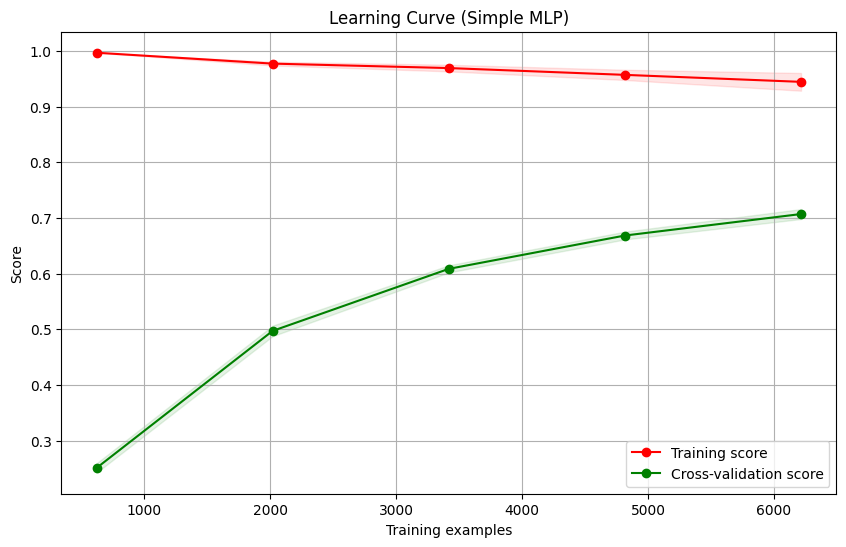

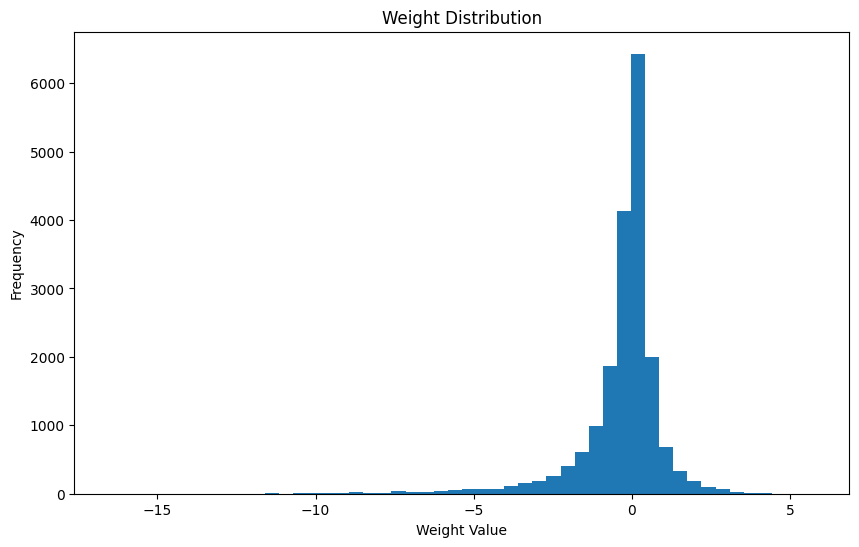

c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Cross-validation scores: [0.6969112  0.7020592  0.71235521 0.7020592  0.71925306]
Mean CV score: 0.7065 (+/- 0.0162)
Test Accuracy: 0.7625
F1-score: 0.7596
Precision: 0.7719
Recall: 0.7625

Classification Report:
               precision    recall  f1-score   support

     Abundant       0.71      0.92      0.80        13
       Active       0.62      0.71      0.67        14
        Adult       0.79      0.85      0.81        13
        Agile       0.71      0.86      0.77        14
     Alluring       0.62      0.62      0.62        13
      Amiable       0.68      0.93      0.79        14
      Amusing       0.92      0.85      0.88        13
      Aqueous       0.76      1.00      0.87        13
 Aristocratic       0.93      1.00      0.97        14
     Aromatic       0.92      0.79      0.85        14
     Artistic       0.93      1.00      0.96        13
Authoritative       0.69      0.85      0.76        13
       Bitter       0.93      1.00      0.96        13
      Bitterl   

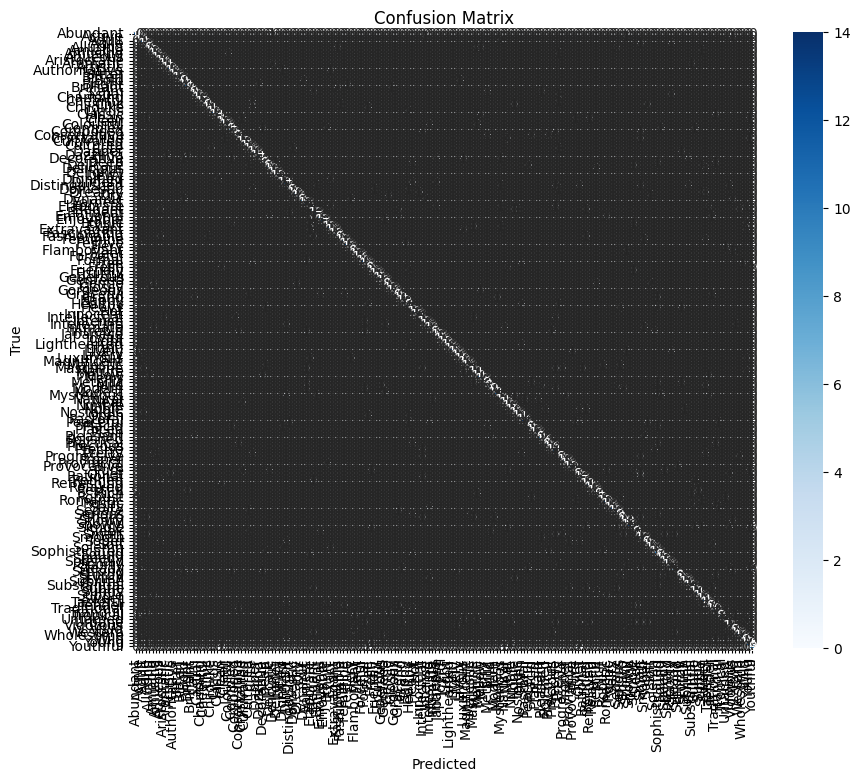

Number of parameters: 19382

Model Fit Analysis:
Train Accuracy: 0.9665
Validation Accuracy: 0.7560
Test Accuracy: 0.7625
Model may be overfitting: Training accuracy is significantly higher than validation and test accuracies.

Difference between Train and Validation accuracy: 0.2105
Difference between Train and Test accuracy: 0.2041
Difference between Validation and Test accuracy: 0.0064


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load and preprocess data
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

def train_and_evaluate(model, X_train, y_train, X_val, y_val):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    train_accuracy = model.score(X_train, y_train)
    val_accuracy = model.score(X_val, y_val)
    
    return model, train_accuracy, val_accuracy, training_time

def plot_learning_curve(model, X, y, title):
    train_sizes = np.linspace(0.1, 1.0, 5)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=5, n_jobs=-1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def plot_weight_distribution(model):
    plt.figure(figsize=(10, 6))
    weights = np.concatenate([layer.flatten() for layer in model.coefs_])
    plt.hist(weights, bins=50)
    plt.title('Weight Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Simple MLP model
simple_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
simple_model, train_acc, val_acc, training_time = train_and_evaluate(
    simple_model, X_train_scaled, y_train, X_val_scaled, y_val)

print(f"Simple MLP - Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
print(f"Training Time: {training_time:.2f} seconds")

# Plot learning curve
plot_learning_curve(simple_model, X_train_scaled, y_train, "Learning Curve (Simple MLP)")

# Plot weight distribution
plot_weight_distribution(simple_model)

# Cross-validation
cv_scores = cross_val_score(simple_model, X_train_scaled, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Final evaluation on test set
test_accuracy = simple_model.score(X_test_scaled, y_test)
y_pred = simple_model.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, le.classes_)

# Model complexity
n_params = sum(p.size for p in simple_model.coefs_) + sum(p.size for p in simple_model.intercepts_)
print(f"Number of parameters: {n_params}")

# Check for overfitting/underfitting
print("\nModel Fit Analysis:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

if train_acc > val_acc + 0.05 and train_acc > test_accuracy + 0.05:
    print("Model may be overfitting: Training accuracy is significantly higher than validation and test accuracies.")
elif train_acc < val_acc - 0.05 and train_acc < test_accuracy - 0.05:
    print("Model may be underfitting: Training accuracy is significantly lower than validation and test accuracies.")
else:
    print("Model fit seems reasonable: Training, validation, and test accuracies are close.")

# Additional overfitting/underfitting check
train_val_diff = abs(train_acc - val_acc)
train_test_diff = abs(train_acc - test_accuracy)
val_test_diff = abs(val_acc - test_accuracy)

print(f"\nDifference between Train and Validation accuracy: {train_val_diff:.4f}")
print(f"Difference between Train and Test accuracy: {train_test_diff:.4f}")
print(f"Difference between Validation and Test accuracy: {val_test_diff:.4f}")

if train_val_diff > 0.1 or train_test_diff > 0.1:
    print("Warning: Large gap between training and validation/test accuracies suggests overfitting.")
elif train_acc < 0.8 * max(val_acc, test_accuracy):
    print("Warning: Training accuracy much lower than validation/test accuracies suggests underfitting.")
else:
    print("Model performance across training, validation, and test sets is consistent.")

#### Oservations:

- Overfitting: The model is clearly overfitting. The training accuracy (96.65%) is significantly higher than both the validation (75.60%) and test (76.25%) accuracies. This large gap (about 21%) indicates that the model has memorized the training data but fails to generalize well to unseen data.

- Generalization: Despite the overfitting, the model's performance on the validation and test sets is consistent (75.60% vs 76.25%), which is a positive sign.

- Model Complexity: With 19,382 parameters, the model is relatively complex for a simple MLP, which might contribute to overfitting.

- Learning Curve: The learning curve plot shows a clear divergence between training and cross-validation scores as the number of training examples increases, further confirming overfitting.

- Weight Distribution: The weight distribution is centered around zero with a bell-curve shape, which is generally good. However, there are some outliers with large positive and negative values, which might indicate some neurons are overly specialized.

- Confusion Matrix: The confusion matrix shows that the model performs well for some classes but struggles with others. There's a visible diagonal pattern, indicating that the model has learned to distinguish between classes to some extent.

- Classification Report: The model's performance varies significantly across different classes. Some classes have high precision and recall (e.g., "Abundant", "Amiable"), while others perform poorly (e.g., "Simple", "Urbane").ey observations:


### I suggest trying the following:

- Implement L2 regularization to constrain the model's weights.
- Reduce the model's complexity by decreasing the number of neurons in the hidden layer.
- Implement early stopping to prevent the model from overfitting during training.
- If available, try a version with dropout to reduce overfitting.


### This version version includes all the necessary evaluations and comparisons between the non-regularized and regularized models.

##### It will allow you to directly assess the impact of L2 regularization on your model's performance and generalization ability


Training model without regularization:
Fold 1 - Accuracy: 0.7936
Fold 2 - Accuracy: 0.7854
Fold 3 - Accuracy: 0.8048
Fold 4 - Accuracy: 0.7853
Fold 5 - Accuracy: 0.7775
Mean CV Accuracy: 0.7893 (+/- 0.0093)
Training Time: 362.60 seconds


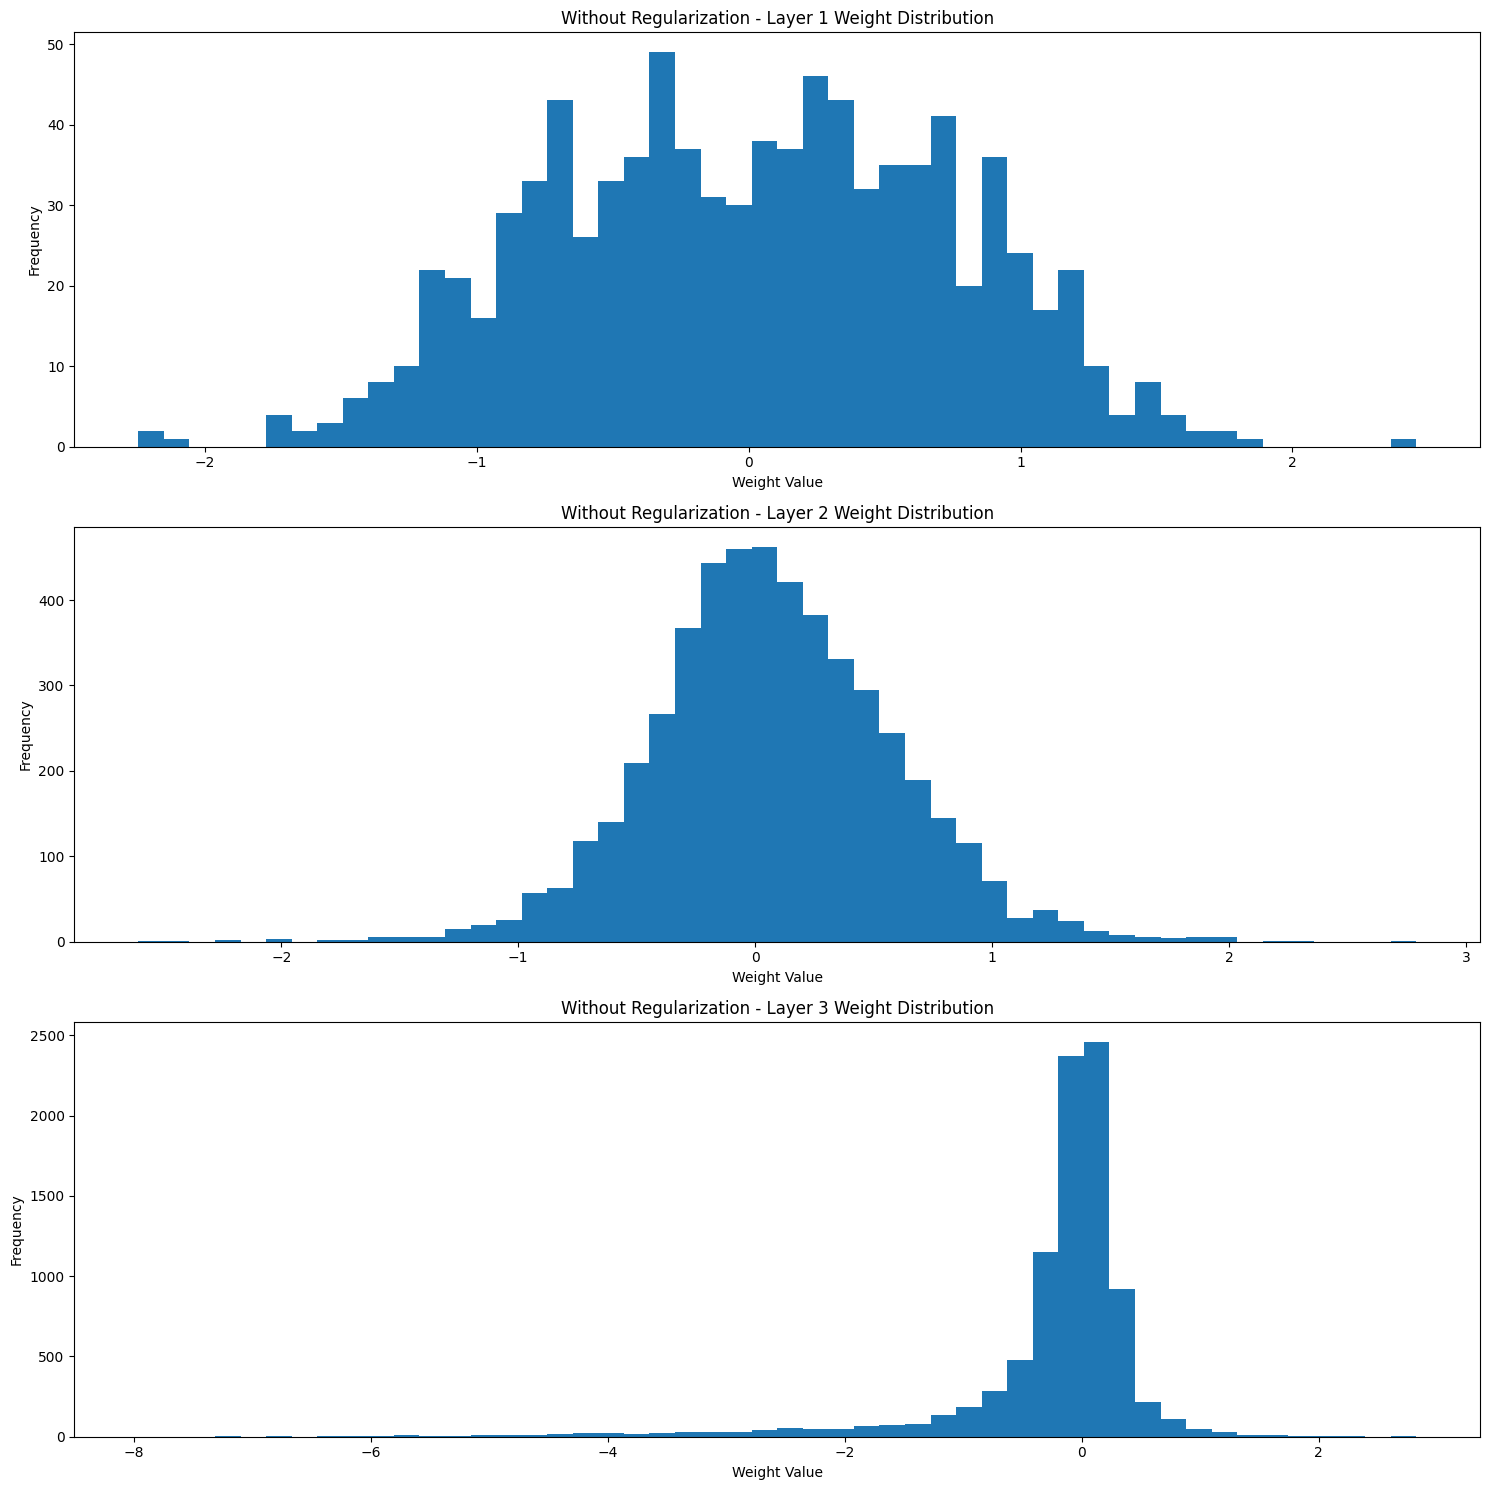


Training model with L2 regularization:
Fold 1 - Accuracy: 0.7983
Fold 2 - Accuracy: 0.7859
Fold 3 - Accuracy: 0.7976
Fold 4 - Accuracy: 0.7878
Fold 5 - Accuracy: 0.7770
Mean CV Accuracy: 0.7893 (+/- 0.0079)
Training Time: 358.16 seconds


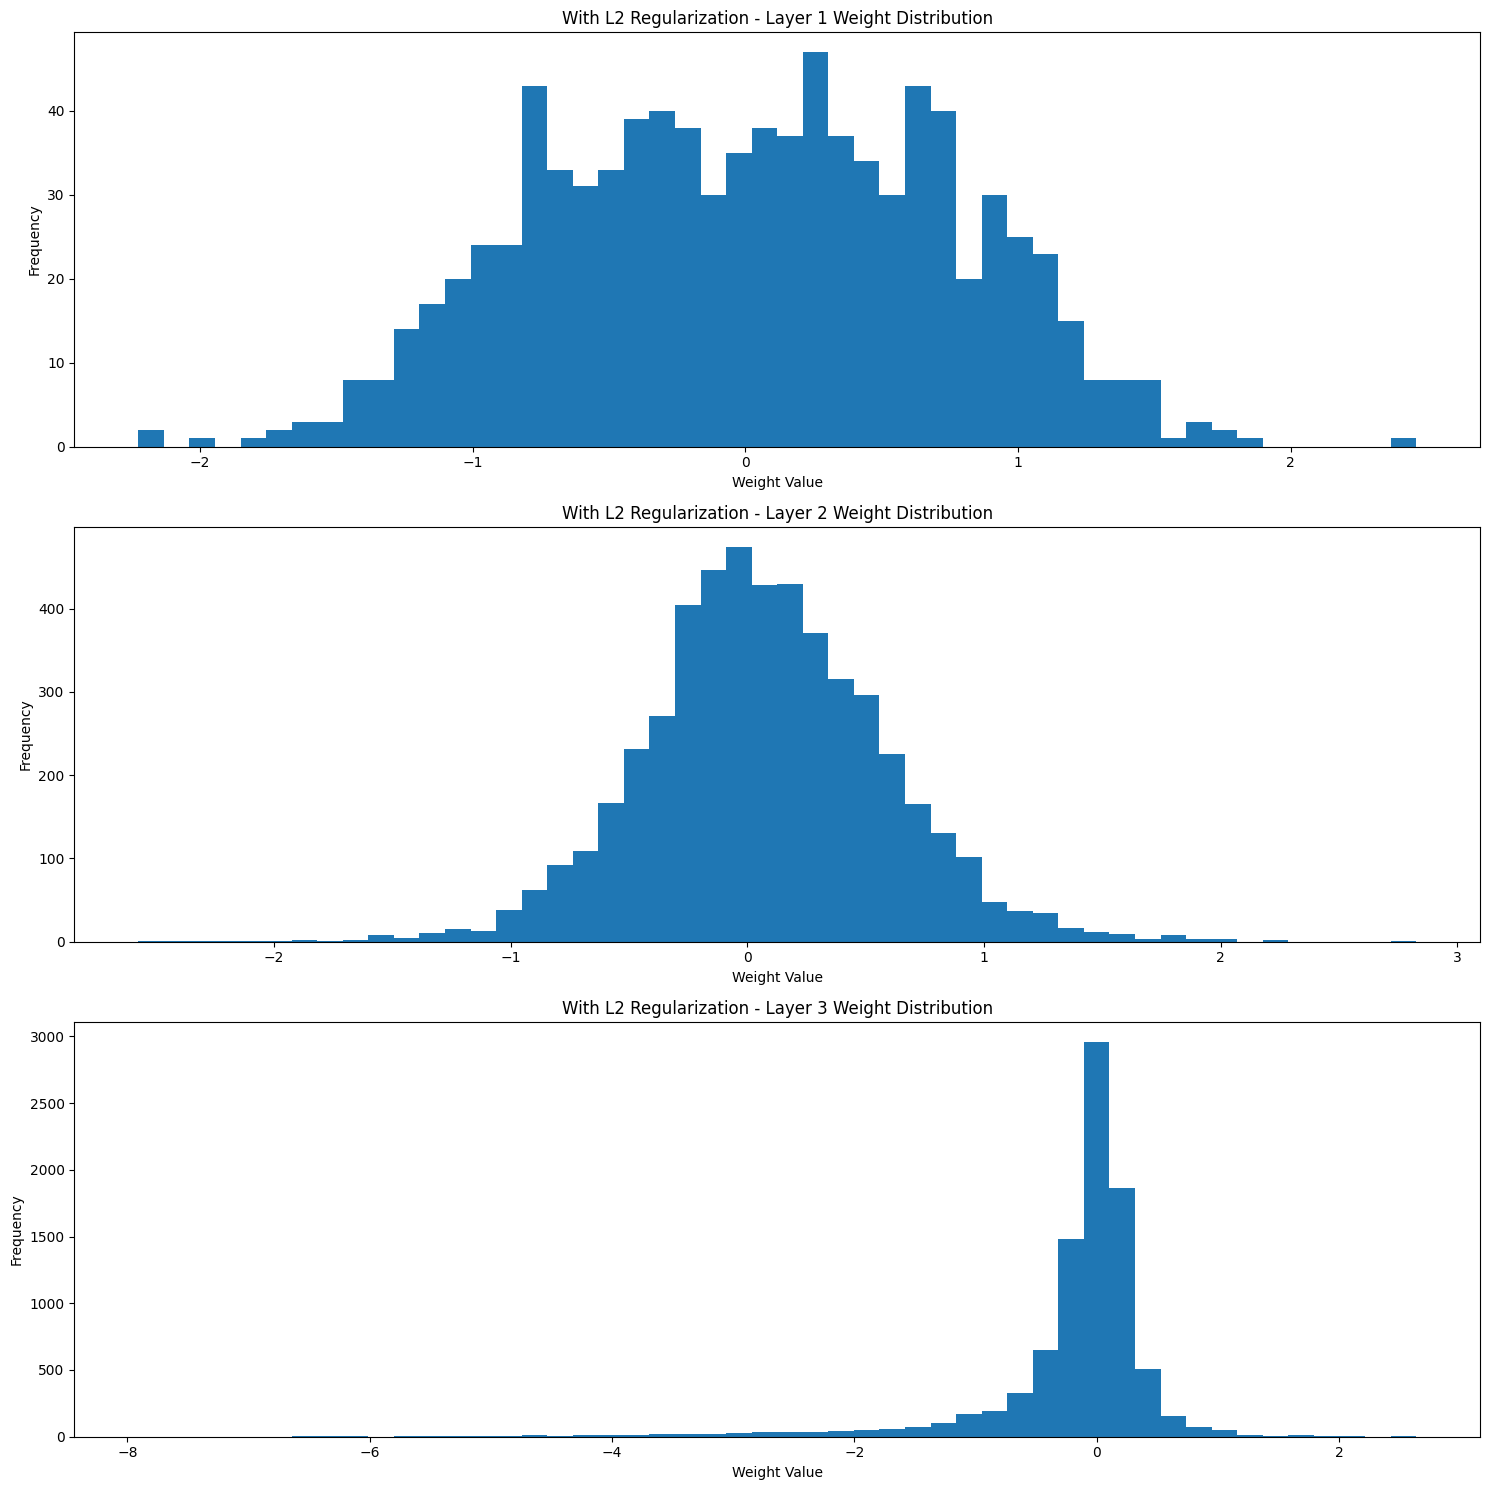


Weight statistics:
Layer 1:
  Without regularization - Max: 2.4552, Mean: 0.6186, Std: 0.7408
  With regularization    - Max: 2.4606, Mean: 0.6189, Std: 0.7415
Layer 2:
  Without regularization - Max: 2.7886, Mean: 0.3963, Std: 0.5102
  With regularization    - Max: 2.8257, Mean: 0.3972, Std: 0.5107
Layer 3:
  Without regularization - Max: 7.9640, Mean: 0.4473, Std: 0.8582
  With regularization    - Max: 7.9100, Mean: 0.3992, Std: 0.7766

Without Regularization Evaluation:
Accuracy: 0.7880
F1-score: 0.7836
Precision: 0.8025
Recall: 0.7880

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.86      0.43      0.57        14
           2       0.83      0.77      0.80        13
           3       0.91      0.71      0.80        14
           4       0.73      0.62      0.67        13
           5       0.91      0.71      0.80        14
           6       1.00      0.85      0.92        

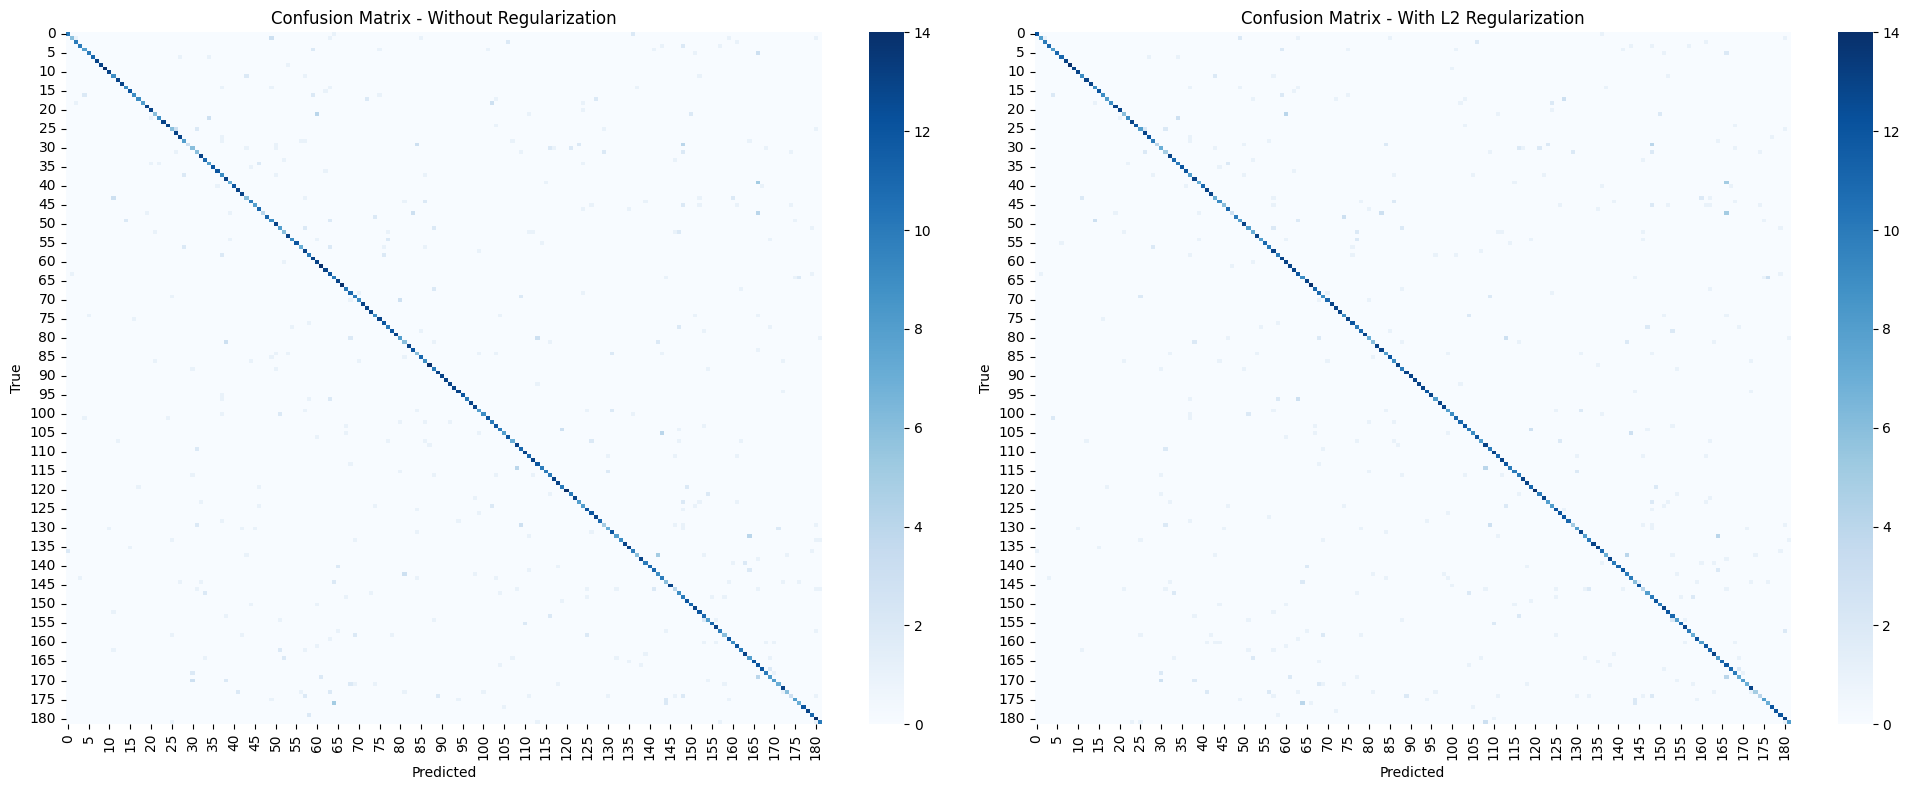

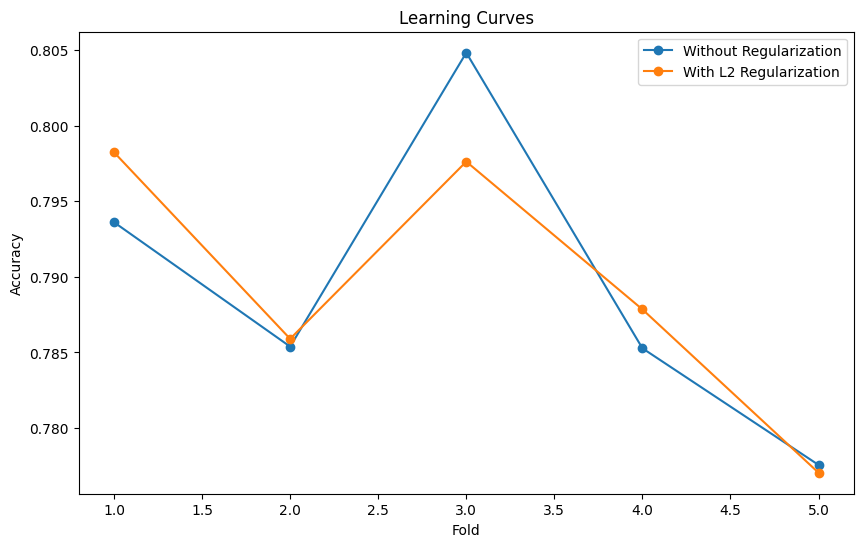


Model Fitting Analysis:
Without Regularization: Model may be overfitting
With L2 Regularization: Model may be overfitting

Model Complexity:
Without Regularization: 15332 parameters
With L2 Regularization: 15332 parameters


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load and preprocess data
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Function to get MLP weights
def get_mlp_weights(mlp):
    return mlp.coefs_

# Function to plot weight distributions
def plot_weight_distributions(weights, title):
    plt.figure(figsize=(15, 5 * len(weights)))
    for i, w in enumerate(weights):
        plt.subplot(len(weights), 1, i+1)
        plt.hist(w.flatten(), bins=50)
        plt.title(f'{title} - Layer {i+1} Weight Distribution')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def train_and_evaluate(X, y, alpha, max_iter=1000):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), alpha=alpha, max_iter=max_iter, random_state=42))
    ])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    start_time = time.time()

    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        pipeline.fit(X_train_fold, y_train_fold)
        y_pred = pipeline.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_pred)
        accuracies.append(accuracy)

        print(f"Fold {fold} - Accuracy: {accuracy:.4f}")

    training_time = time.time() - start_time
    print(f"Mean CV Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")
    print(f"Training Time: {training_time:.2f} seconds")
    return pipeline, accuracies

# Train model without regularization
print("Training model without regularization:")
model_noreg, accuracies_noreg = train_and_evaluate(X_train, y_train, alpha=0)

# Get weights without regularization
weights_noreg = get_mlp_weights(model_noreg.named_steps['mlp'])
plot_weight_distributions(weights_noreg, "Without Regularization")

# Train model with L2 regularization
print("\nTraining model with L2 regularization:")
model_reg, accuracies_reg = train_and_evaluate(X_train, y_train, alpha=0.0001)  # You can adjust alpha

# Get weights with regularization
weights_reg = get_mlp_weights(model_reg.named_steps['mlp'])
plot_weight_distributions(weights_reg, "With L2 Regularization")

# Compare weight statistics
print("\nWeight statistics:")
for i, (w_noreg, w_reg) in enumerate(zip(weights_noreg, weights_reg)):
    print(f"Layer {i+1}:")
    print(f"  Without regularization - Max: {np.max(np.abs(w_noreg)):.4f}, Mean: {np.mean(np.abs(w_noreg)):.4f}, Std: {np.std(w_noreg):.4f}")
    print(f"  With regularization    - Max: {np.max(np.abs(w_reg)):.4f}, Mean: {np.mean(np.abs(w_reg)):.4f}, Std: {np.std(w_reg):.4f}")

# Evaluate on test set
y_pred_noreg = model_noreg.predict(X_test)
y_pred_reg = model_reg.predict(X_test)

def print_evaluation(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

print_evaluation(y_test, y_pred_noreg, "Without Regularization")
print_evaluation(y_test, y_pred_reg, "With L2 Regularization")

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_noreg), annot=False, cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix - Without Regularization')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
sns.heatmap(confusion_matrix(y_test, y_pred_reg), annot=False, cmap='Blues', ax=ax2)
ax2.set_title('Confusion Matrix - With L2 Regularization')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')
plt.tight_layout()
plt.show()

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), accuracies_noreg, marker='o', label='Without Regularization')
plt.plot(range(1, 6), accuracies_reg, marker='o', label='With L2 Regularization')
plt.title('Learning Curves')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Check for overfitting/underfitting
def check_fitting(train_acc, val_acc, test_acc):
    if train_acc > val_acc + 0.05 and train_acc > test_acc + 0.05:
        return "Model may be overfitting"
    elif train_acc < val_acc - 0.05 and train_acc < test_acc - 0.05:
        return "Model may be underfitting"
    else:
        return "Model fit seems reasonable"

train_acc_noreg = model_noreg.score(X_train, y_train)
val_acc_noreg = np.mean(accuracies_noreg)
test_acc_noreg = accuracy_score(y_test, y_pred_noreg)

train_acc_reg = model_reg.score(X_train, y_train)
val_acc_reg = np.mean(accuracies_reg)
test_acc_reg = accuracy_score(y_test, y_pred_reg)

print("\nModel Fitting Analysis:")
print("Without Regularization:", check_fitting(train_acc_noreg, val_acc_noreg, test_acc_noreg))
print("With L2 Regularization:", check_fitting(train_acc_reg, val_acc_reg, test_acc_reg))

# Print model complexity
def count_parameters(mlp):
    return sum(p.size for p in mlp.coefs_) + sum(p.size for p in mlp.intercepts_)

print("\nModel Complexity:")
print(f"Without Regularization: {count_parameters(model_noreg.named_steps['mlp'])} parameters")
print(f"With L2 Regularization: {count_parameters(model_reg.named_steps['mlp'])} parameters")

### Observationss

The new code is more complex and sophisticated than the previous version. It includes:

- Stratified K-Fold cross-validation
- A pipeline for preprocessing and model training
- More detailed evaluation metrics and visualizations
- Weight distribution analysis
- Comparison between models with and without L2 regularization

Test Accuracy (Without): 0.7880
Test Accuracy (With): 0.7900
The new models show improved accuracy compared to the previous implementation.

- Overfitting: Both models are flagged as potentially overfitting, suggesting that L2 regularization alone isn't sufficient to address this issue.

- Weight Distributions: The weight distributions are very similar between the two models, with the L2 regularized model showing slightly more concentrated weights around zero in the output layer.

- Learning Curves: The learning curves show that the L2 regularized model has slightly more consistent performance across folds, but the difference is minima


### Update the code !


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters: {'dropout__dropout_rate': 0.2, 'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (200, 100), 'mlp__learning_rate': 'constant', 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
Best cross-validation score: 0.25566323006933445
Training Time: 6094.51 seconds

Test set accuracy: 0.2630712227254014

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.54      0.48        13
           1       0.00      0.00      0.00        14
           2       0.23      0.23      0.23        13
           3       0.32      0.79      0.46        14
           4       0.20      0.15      0.17        13
           5       0.10      0.07      0.08        14
           6       0.50      0.38      0.43        13
           7       0.41      0.69      0.51        13
           8       0.32      0.71      0.44        14
           9       0.45    

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


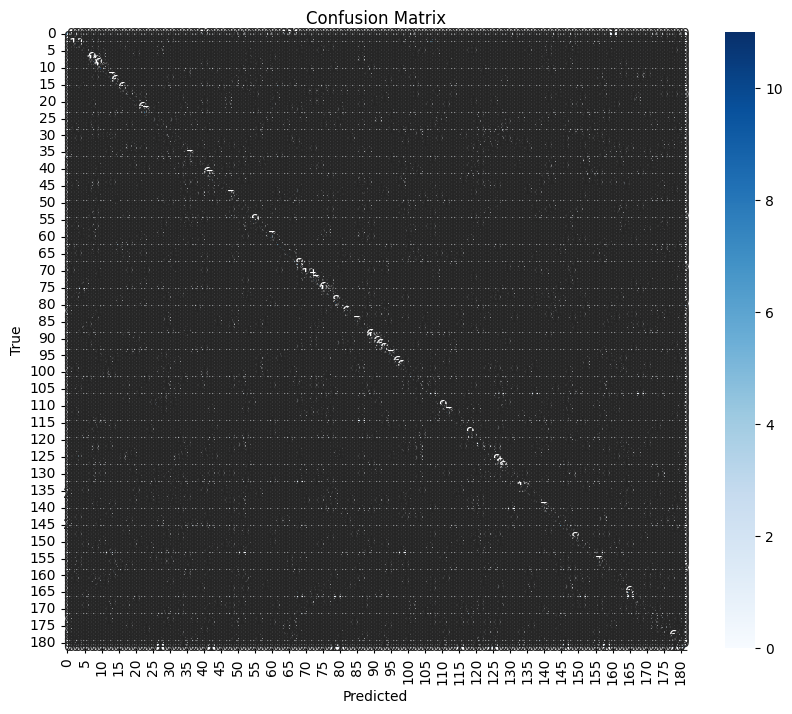

KeyError: 'mean_train_score'

<Figure size 1000x600 with 0 Axes>

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Custom Dropout Layer
class DropoutLayer(BaseEstimator, TransformerMixin):
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        mask = np.random.binomial(1, 1-self.dropout_rate, size=X.shape)
        return X * mask / (1 - self.dropout_rate)

# Load and preprocess data
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dropout', DropoutLayer()),
    ('mlp', MLPClassifier(max_iter=1000, early_stopping=True, random_state=42))
])

# Define the parameter grid
param_grid = {
    'dropout__dropout_rate': [0.2, 0.5],
    'mlp__hidden_layer_sizes': [(100,), (100, 50), (200, 100)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__solver': ['adam', 'sgd']
}

# Set up the grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2, return_train_score=True)

# Fit the grid search
start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print(f"Training Time: {training_time:.2f} seconds")

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("\nTest set accuracy:", test_accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot learning curve for grid search
plt.figure(figsize=(10, 6))
if 'mean_train_score' in grid_search.cv_results_:
    train_scores = grid_search.cv_results_['mean_train_score']
    test_scores = grid_search.cv_results_['mean_test_score']
    plt.plot(range(1, len(train_scores) + 1), train_scores, label='Training Score')
    plt.plot(range(1, len(test_scores) + 1), test_scores, label='Cross-Validation Score')
    plt.xlabel('Grid Search Iterations')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves for Grid Search')
    plt.legend()
else:
    # Alternative: Plot the test scores only
    test_scores = grid_search.cv_results_['mean_test_score']
    plt.plot(range(1, len(test_scores) + 1), test_scores, label='Cross-Validation Score')
    plt.xlabel('Grid Search Iterations')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Scores Across Grid Search Iterations')
    plt.legend()
plt.show()

# Plot learning curve for best model
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Best Model')
plt.legend()
plt.show()

# Function to get MLP weights
def get_mlp_weights(mlp):
    return mlp.named_steps['mlp'].coefs_

# Function to plot weight distributions
def plot_weight_distributions(weights, title):
    plt.figure(figsize=(15, 5 * len(weights)))
    for i, w in enumerate(weights):
        plt.subplot(len(weights), 1, i+1)
        plt.hist(w.flatten(), bins=50)
        plt.title(f'{title} - Layer {i+1} Weight Distribution')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Get and plot weight distributions
weights = get_mlp_weights(best_model)
plot_weight_distributions(weights, "Best Model")

# Print model complexity
def count_parameters(mlp):
    return sum(p.size for p in mlp.named_steps['mlp'].coefs_) + sum(p.size for p in mlp.named_steps['mlp'].intercepts_)

print("\nModel Complexity:")
print(f"Number of parameters: {count_parameters(best_model)}")

# Check for overfitting
train_accuracy = best_model.score(X_train, y_train)
print("\nModel Fitting Analysis:")
if train_accuracy > test_accuracy + 0.05:
    print("Model may be overfitting")
elif train_accuracy < test_accuracy - 0.05:
    print("Model may be underfitting")
else:
    print("Model fit seems reasonable")
print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Plot precision-recall curve for each class
y_score = best_model.predict_proba(X_test)
n_classes = y_score.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test == i, y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()

#### Using Ensemble for Improvement:

- Hyperparameter Tuning: The current L2 regularization might not be optimal. RandomizedSearchCV can help find better hyperparameters, including the regularization strength.

- Ensemble Method: The VotingClassifier can combine multiple models, potentially improving generalization and reducing overfitting.

- Early Stopping: This can prevent overfitting by stopping training when validation performance starts to degrade.

- Adaptive Learning Rate: The code uses an adaptive learning rate, which can help in finding a better optimum.


Performing hyperparameter tuning...
Hyperparameter tuning time: 938.95 seconds
Best parameters: {'mlp__alpha': 6.025215736203858e-05, 'mlp__hidden_layer_sizes': (256, 128, 64), 'mlp__learning_rate_init': 0.002386418878005608}
Best cross-validation score: 0.7898481596774818

Performing cross-validation with ensemble...
Fold 1
Train Accuracy: 0.9417
Validation Accuracy: 0.8034

best weights:
Layer 1:
  Max: 0.8890, Mean: 0.2098, Std: 0.2550
Layer 2:
  Max: 1.9880, Mean: 0.1654, Std: 0.2222
Layer 3:
  Max: 1.5257, Mean: 0.1582, Std: 0.2156
Layer 4:
  Max: 2.7616, Mean: 0.1994, Std: 0.3220

model1 weights:
Layer 1:
  Max: 0.8890, Mean: 0.2098, Std: 0.2550
Layer 2:
  Max: 1.9880, Mean: 0.1654, Std: 0.2222
Layer 3:
  Max: 1.5257, Mean: 0.1582, Std: 0.2156
Layer 4:
  Max: 2.7616, Mean: 0.1994, Std: 0.3220

model2 weights:
Layer 1:
  Max: 0.8890, Mean: 0.2098, Std: 0.2550
Layer 2:
  Max: 1.9880, Mean: 0.1654, Std: 0.2222
Layer 3:
  Max: 1.5257, Mean: 0.1582, Std: 0.2156
Layer 4:
  Max: 2.7616,

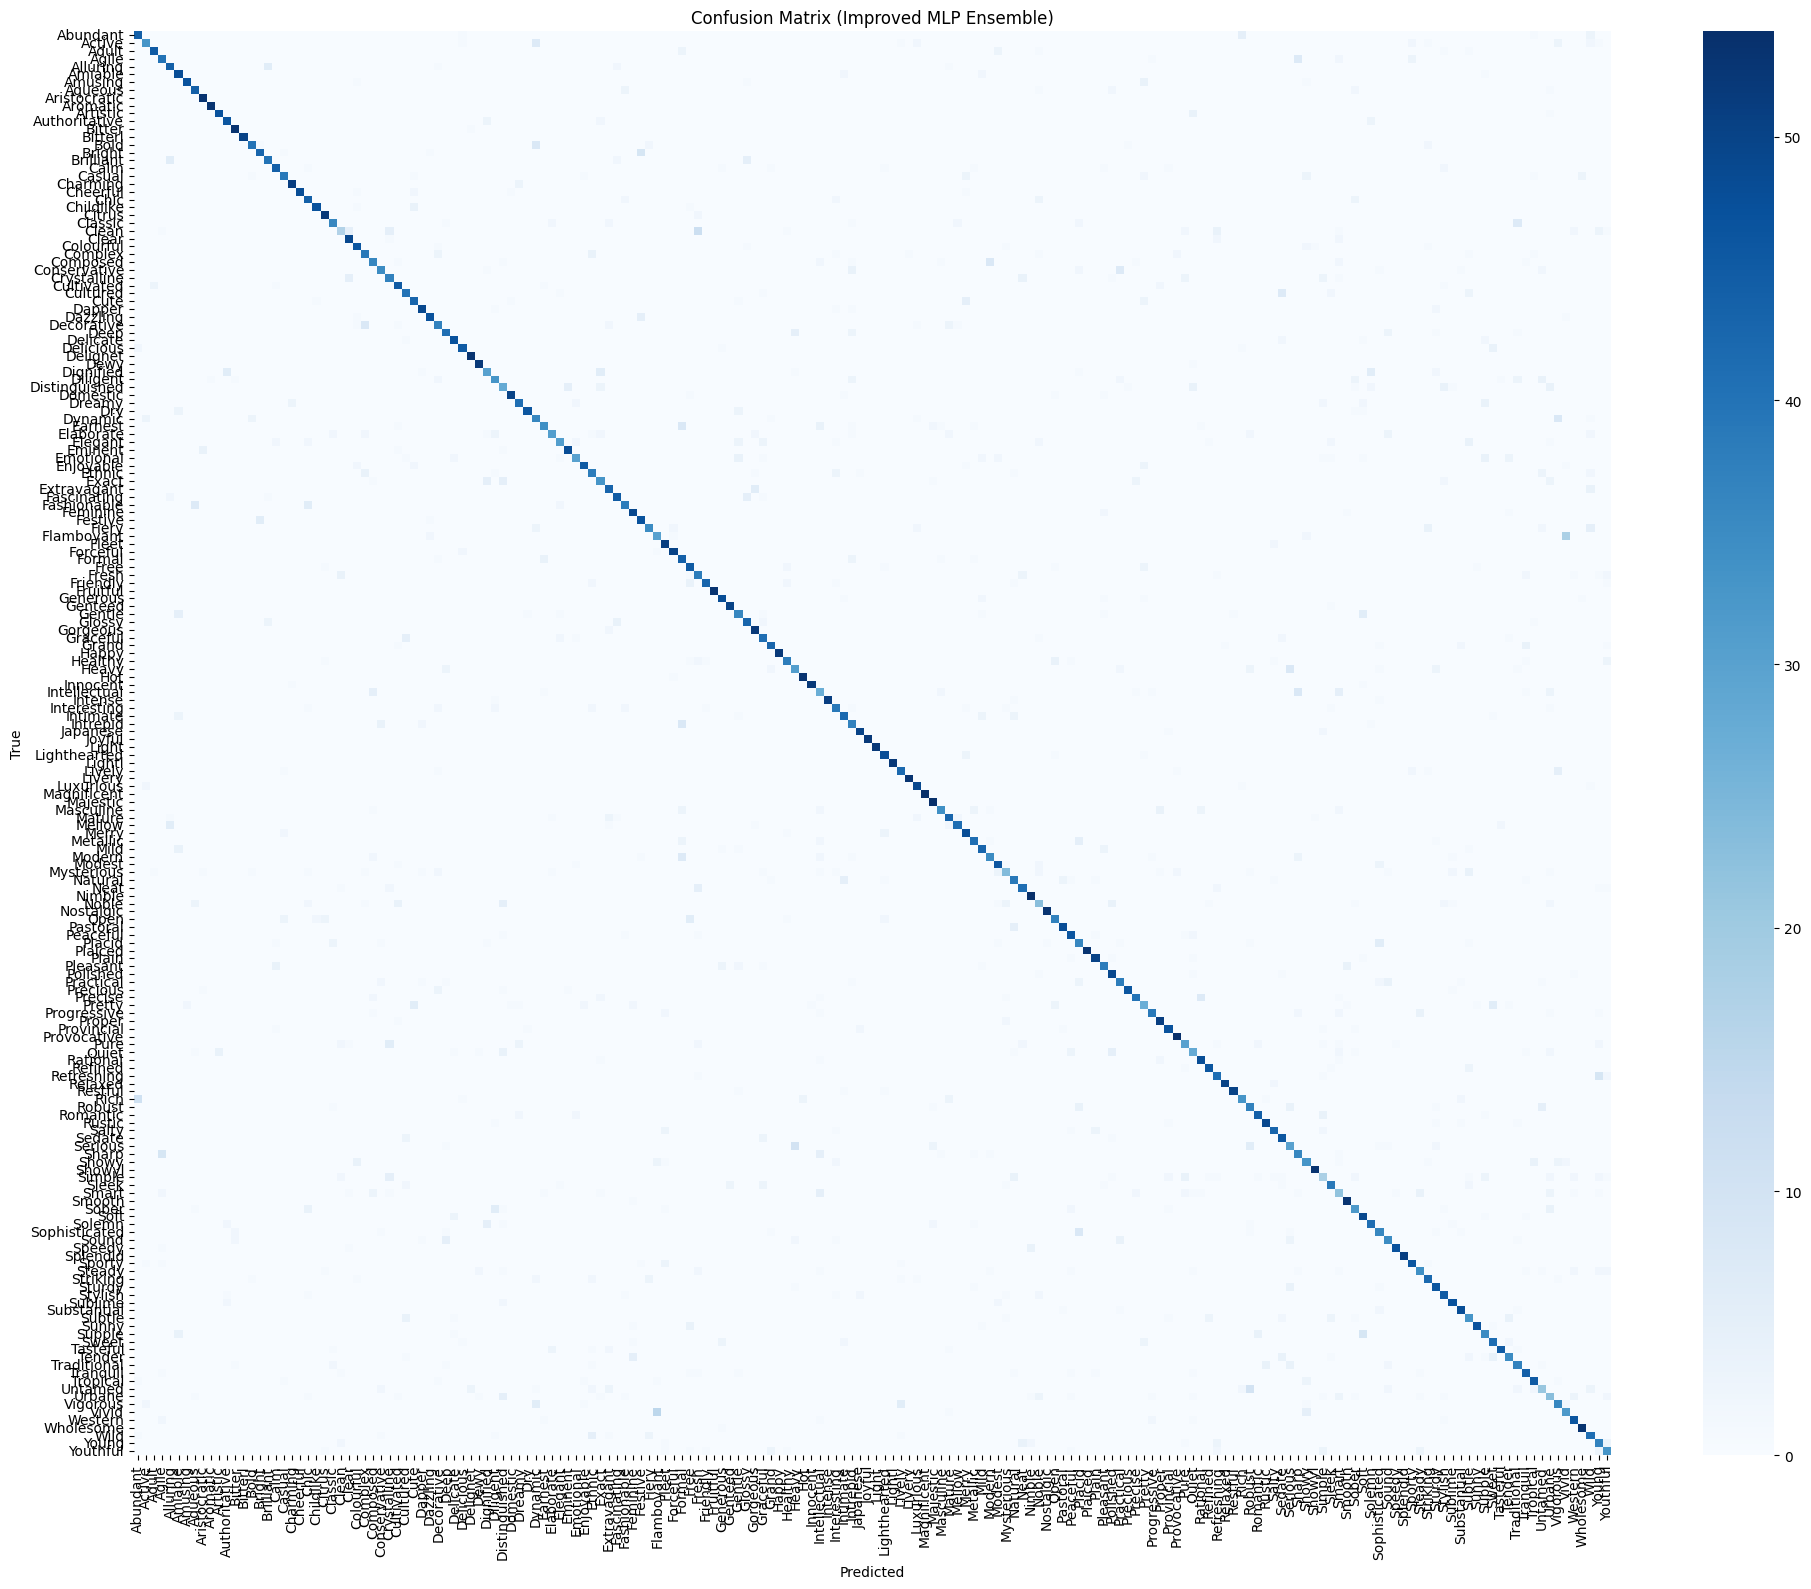

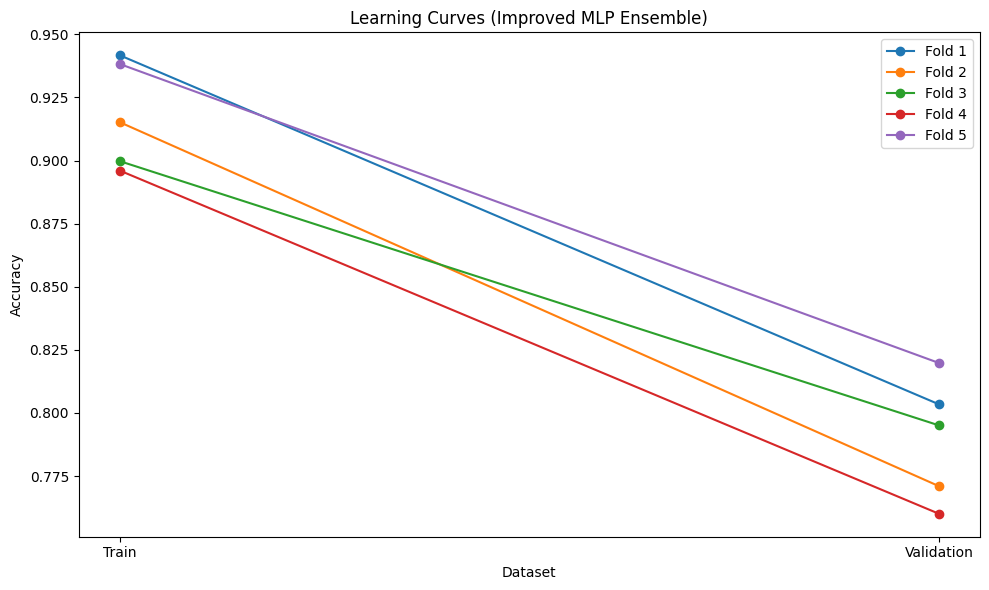

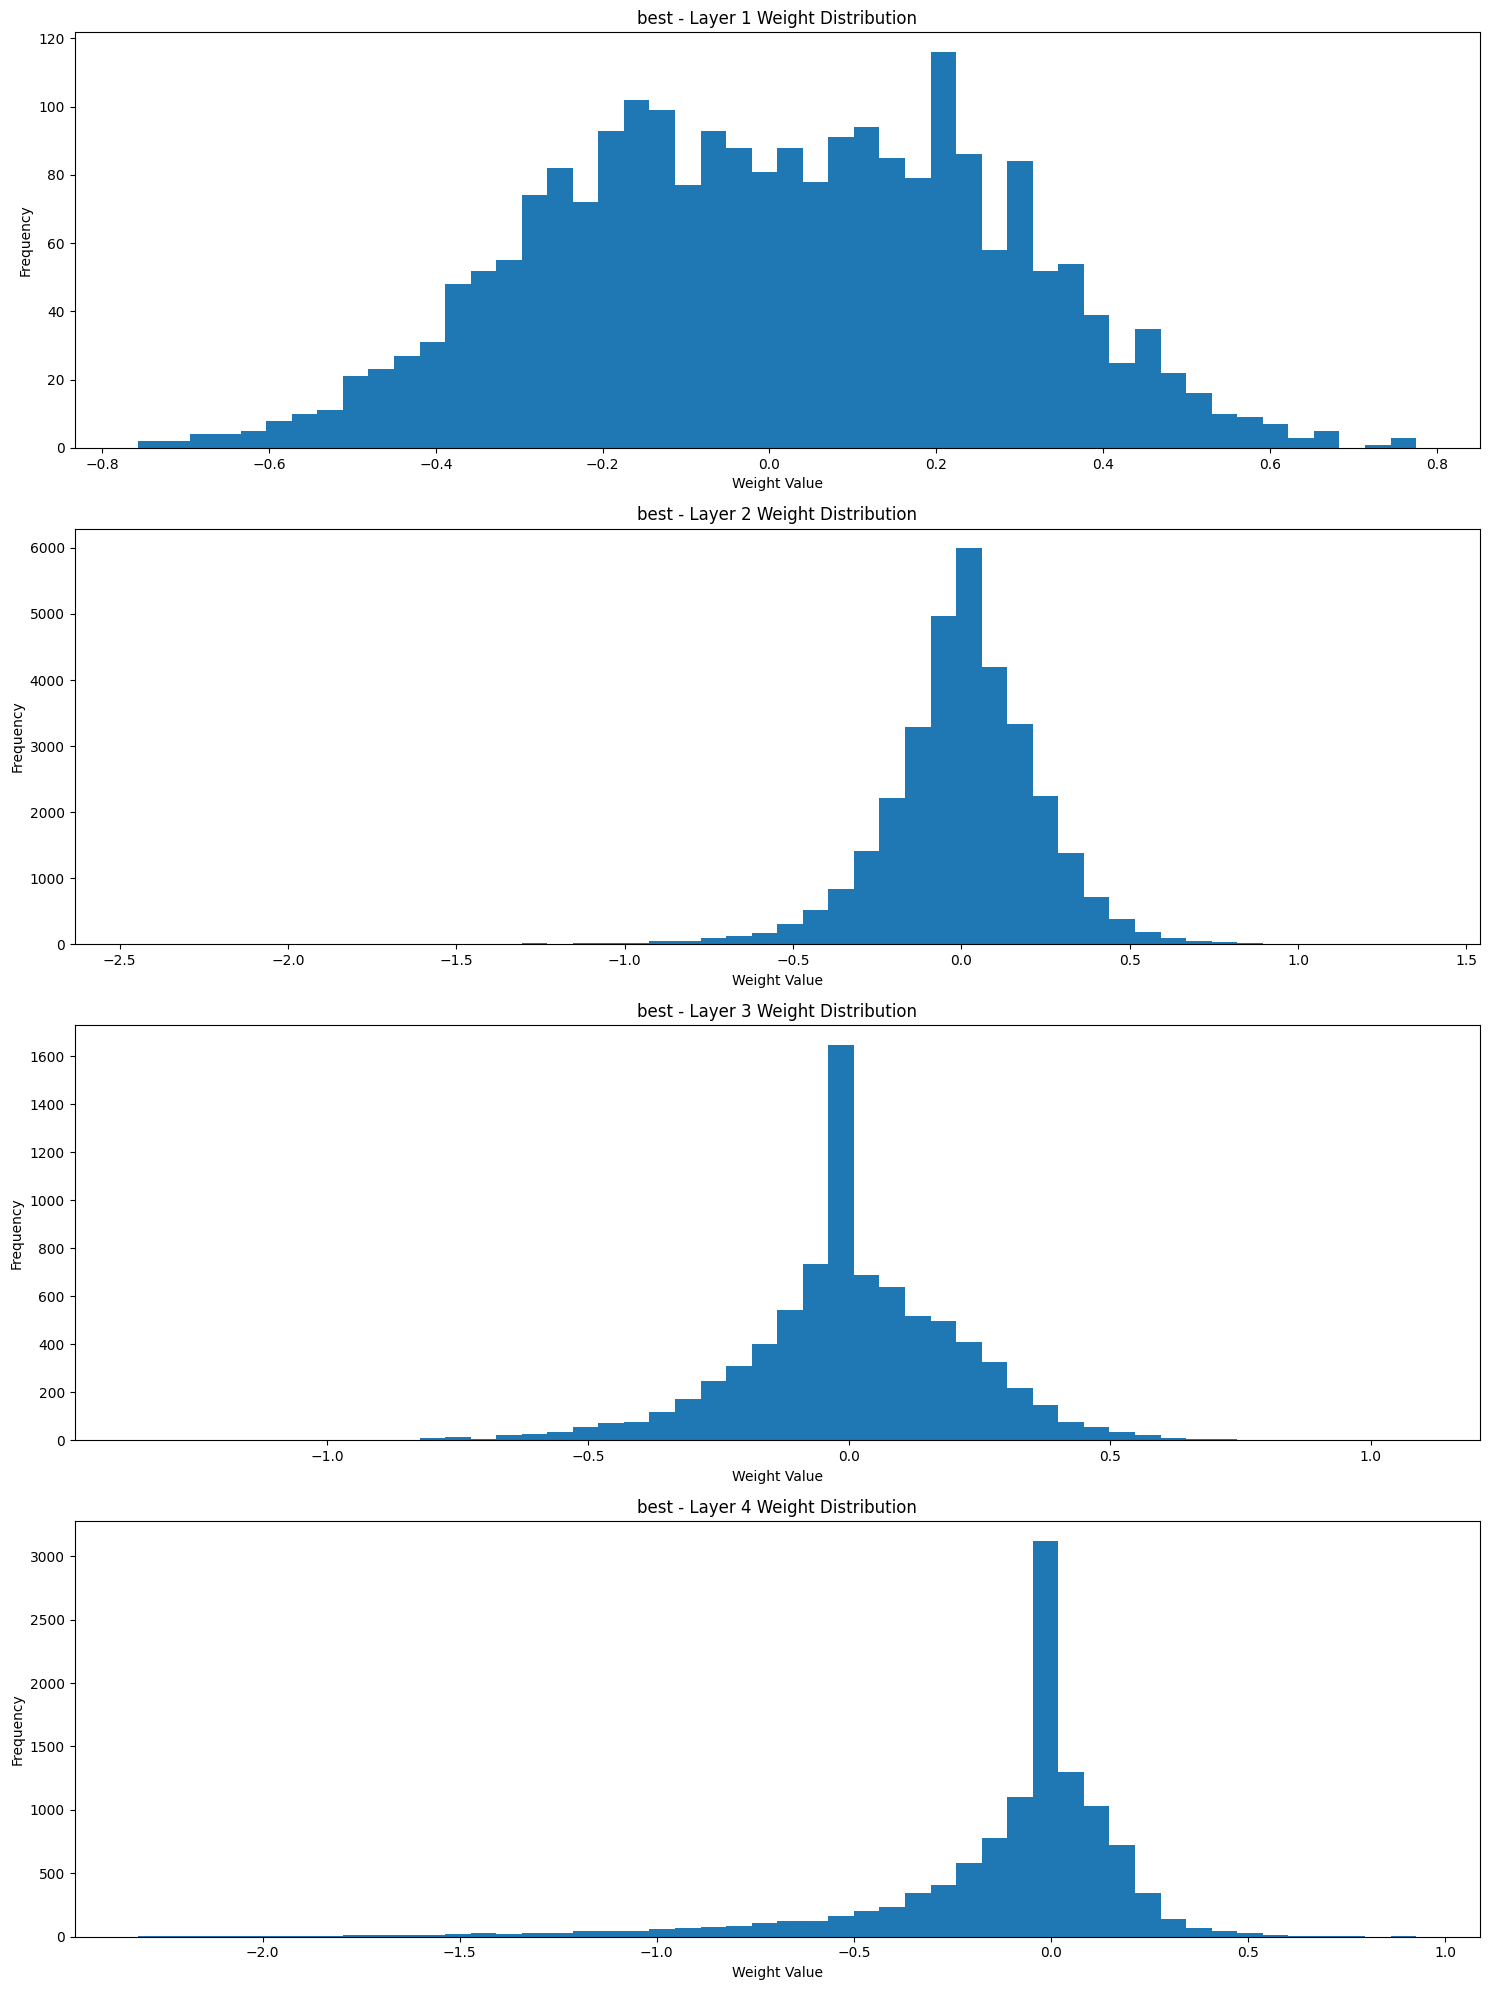

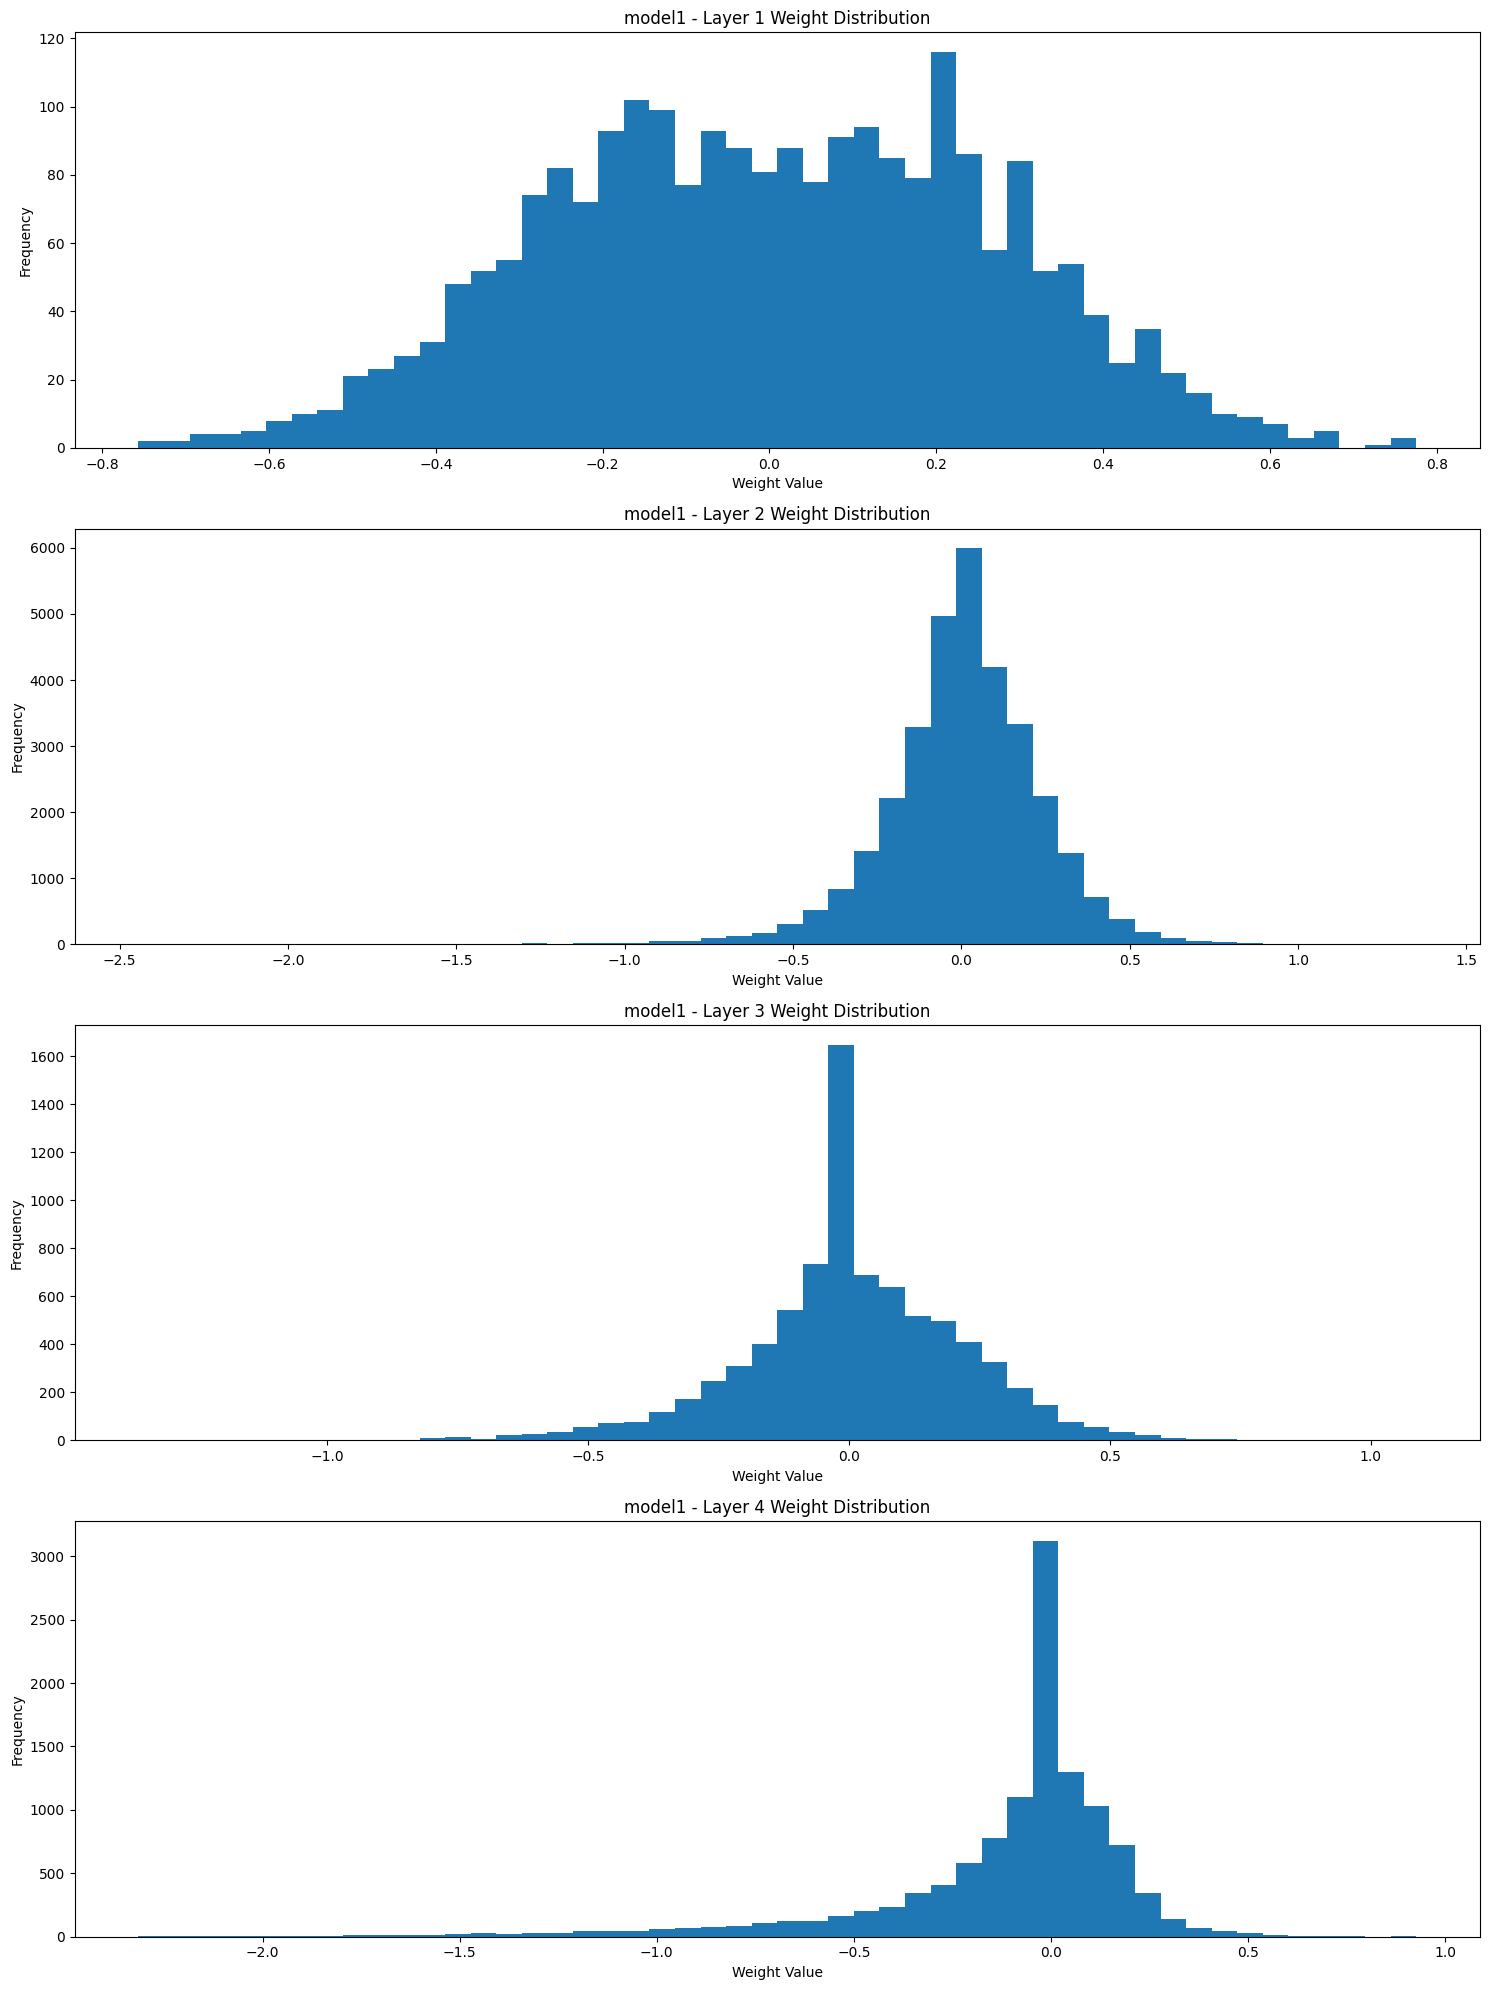

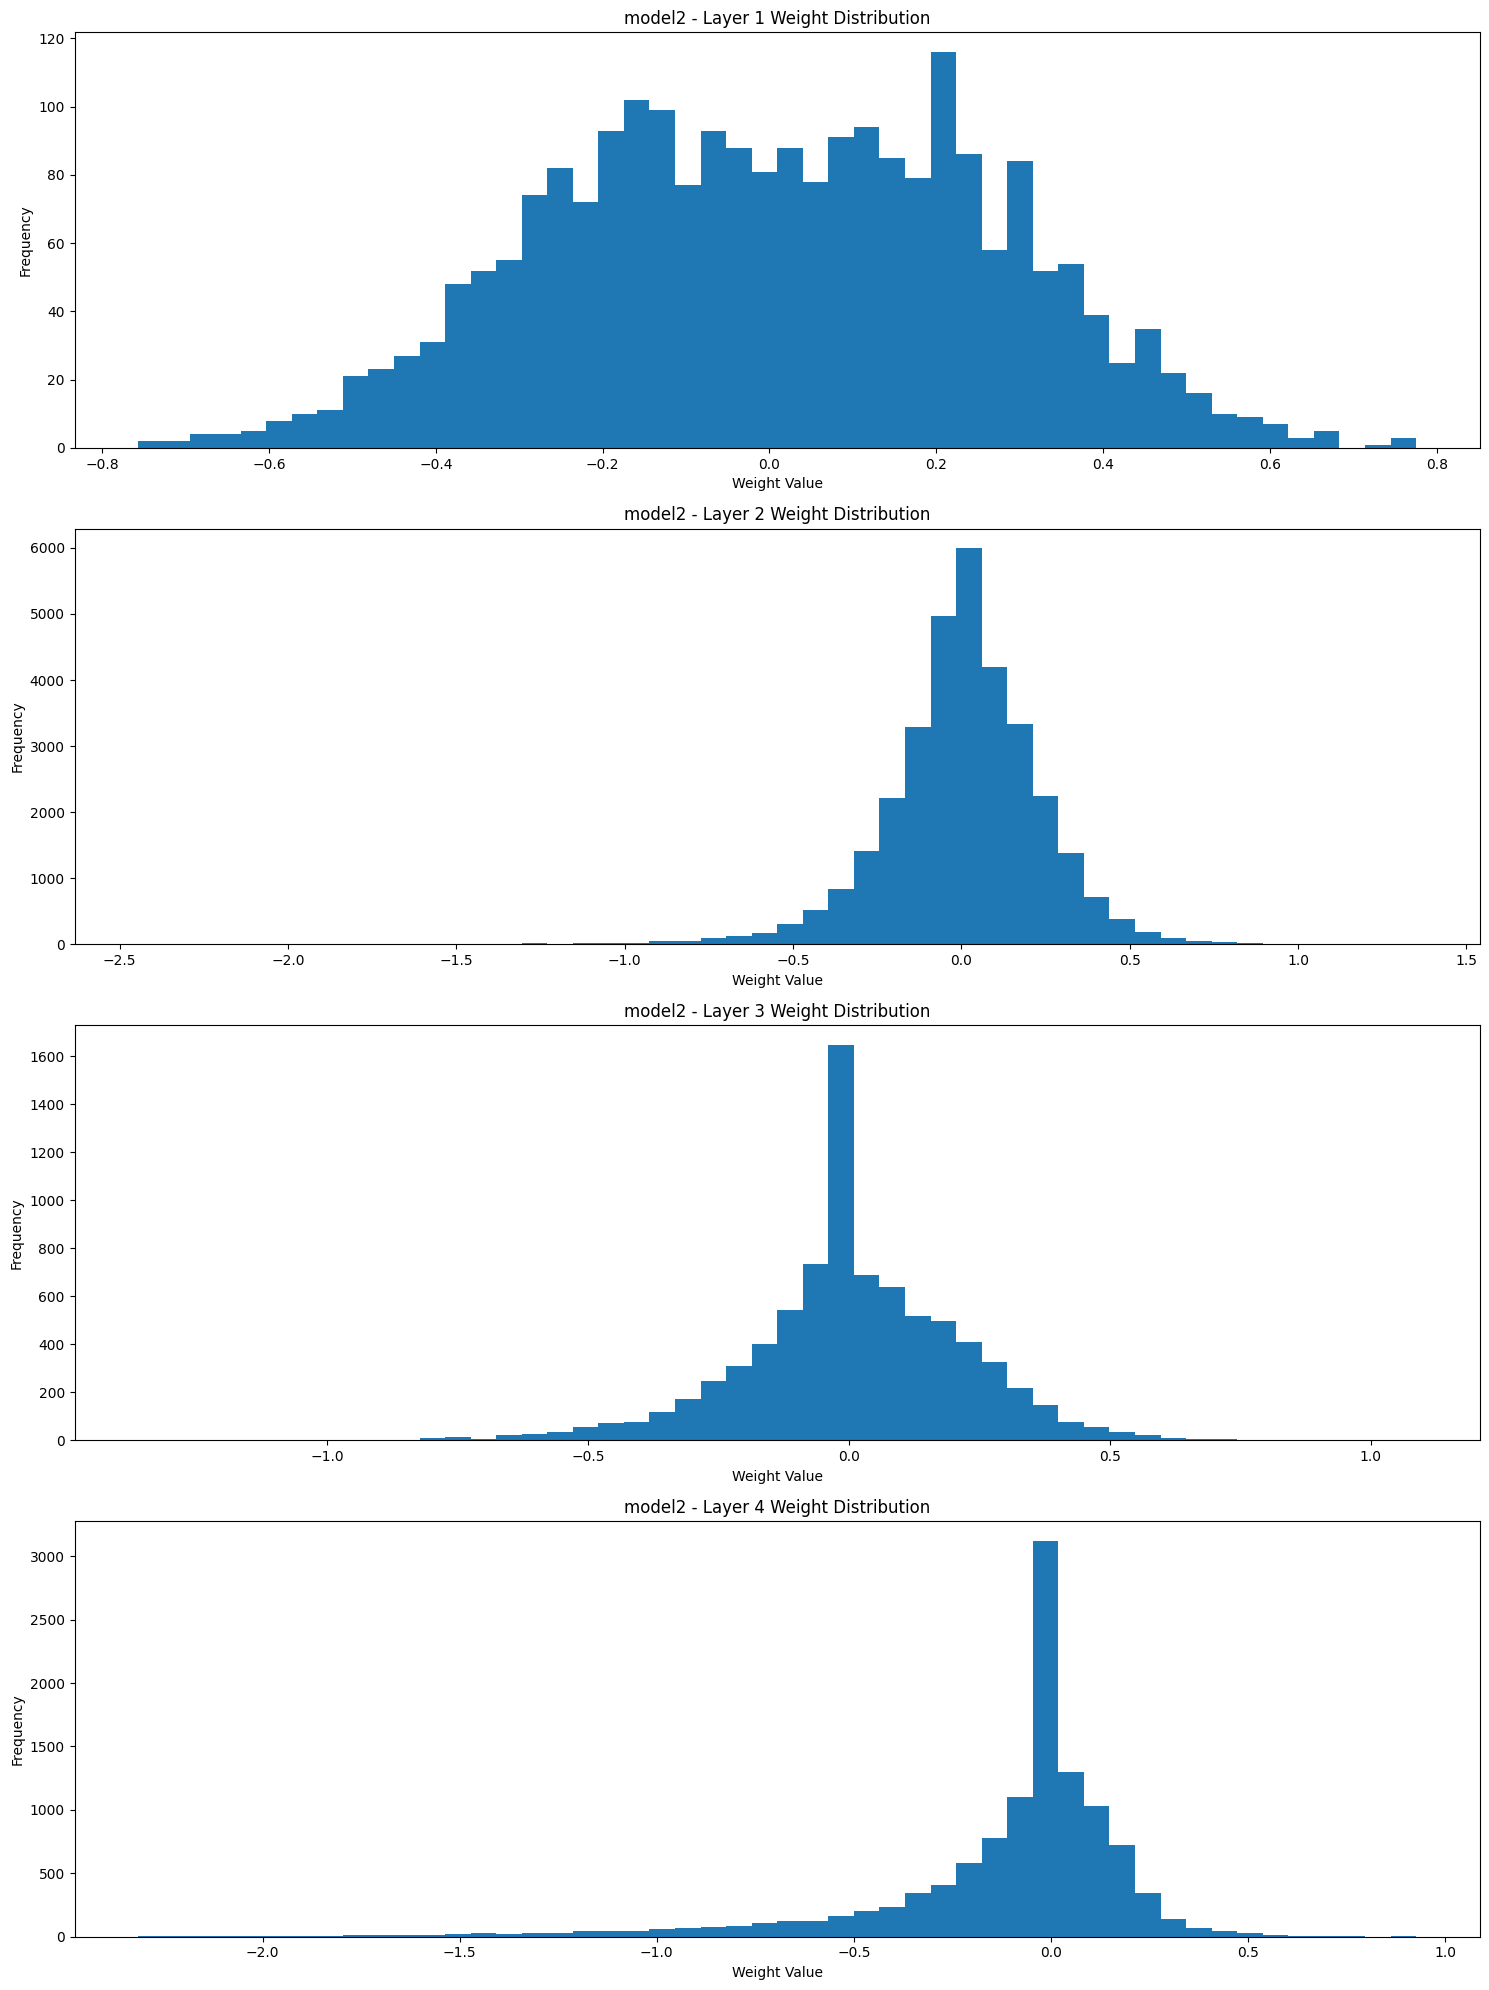


Test Set Evaluation:
Train Accuracy: 0.9336
Test Accuracy: 0.8382
Test F1-score: 0.8344
Test Precision: 0.8550
Test Recall: 0.8382

Model Fitting Analysis: Model may be overfitting

Model Complexity:
best: 55542 parameters
model1: 55542 parameters
model2: 55542 parameters


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from scipy.stats import loguniform
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load and preprocess the data
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the base model
def create_model(hidden_layer_sizes=(100, 50), alpha=0.01, learning_rate_init=0.001):
    return MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        alpha=alpha,
        learning_rate='adaptive',
        learning_rate_init=learning_rate_init,
        max_iter=1000,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=42
    )

# Define the parameter space for random search
param_dist = {
    'mlp__hidden_layer_sizes': [(100, 50), (256, 128), (256, 128, 64), (256, 128, 64, 32)],
    'mlp__alpha': loguniform(1e-5, 1),
    'mlp__learning_rate_init': loguniform(1e-4, 1e-1)
}

# Create a pipeline with StandardScaler and MLPClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', create_model())
])

# Function to check for overfitting/underfitting
def check_fitting(train_acc, val_acc, test_acc):
    if train_acc > val_acc + 0.05 and train_acc > test_acc + 0.05:
        return "Model may be overfitting"
    elif train_acc < val_acc - 0.05 and train_acc < test_acc - 0.05:
        return "Model may be underfitting"
    else:
        return "Model fit seems reasonable"

# Start timing for hyperparameter tuning
tuning_start_time = time.time()

# Perform random search
print("Performing hyperparameter tuning...")
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

tuning_end_time = time.time()
print(f"Hyperparameter tuning time: {tuning_end_time - tuning_start_time:.2f} seconds")
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Function to extract MLP parameters from the best estimator
def extract_mlp_params(best_estimator):
    valid_params = ['hidden_layer_sizes', 'alpha', 'learning_rate_init']
    return {k.split('__')[1]: v for k, v in best_estimator.get_params().items() 
            if k.startswith('mlp__') and k.split('__')[1] in valid_params}

# Create an ensemble of the best model and two variations
best_model = random_search.best_estimator_
best_mlp_params = extract_mlp_params(best_model)

model1 = Pipeline([('scaler', StandardScaler()), ('mlp', create_model(**best_mlp_params))])
model2 = Pipeline([('scaler', StandardScaler()), ('mlp', create_model(**best_mlp_params))])

ensemble = VotingClassifier(
    estimators=[('best', best_model), ('model1', model1), ('model2', model2)],
    voting='soft'
)

# Perform cross-validation with the ensemble
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies = []
train_accuracies = []
all_y_true = []
all_y_pred = []

# Function to extract weights from MLP
def get_mlp_weights(mlp):
    return mlp.named_steps['mlp'].coefs_

ensemble_start_time = time.time()

print("\nPerforming cross-validation with ensemble...")
for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_train_fold, X_val = X_train[train_index], X_train[val_index]
    y_train_fold, y_val = y_train[train_index], y_train[val_index]
    
    ensemble.fit(X_train_fold, y_train_fold)
    y_pred = ensemble.predict(X_val)
    y_pred_train = ensemble.predict(X_train_fold)
    
    train_accuracy = accuracy_score(y_train_fold, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred)
    
    train_accuracies.append(train_accuracy)
    accuracies.append(val_accuracy)
    
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)
    
    print(f"Fold {fold}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Extract and print weights from all models in the ensemble
    for model_name, model in ensemble.named_estimators_.items():
        weights = get_mlp_weights(model)
        print(f"\n{model_name} weights:")
        for i, w in enumerate(weights):
            print(f"Layer {i+1}:")
            print(f"  Max: {np.max(np.abs(w)):.4f}, Mean: {np.mean(np.abs(w)):.4f}, Std: {np.std(w):.4f}")
    print()

ensemble_end_time = time.time()
print(f"Ensemble training time: {ensemble_end_time - ensemble_start_time:.2f} seconds")

print("\nImproved MLP (Ensemble) Results:")
print(f"Mean Train Accuracy: {np.mean(train_accuracies):.4f} (+/- {np.std(train_accuracies):.4f})")
print(f"Mean Validation Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")

# Calculate and print F1-score, precision, and recall
f1 = f1_score(all_y_true, all_y_pred, average='weighted')
precision = precision_score(all_y_true, all_y_pred, average='weighted')
recall = recall_score(all_y_true, all_y_pred, average='weighted')
print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Print total training time
print(f"Total training time: {ensemble_end_time - tuning_start_time:.2f} seconds")

# Generate classification report
class_names = le.classes_
print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=class_names))

# Generate confusion matrix
plt.figure(figsize=(20, 16))
cm = confusion_matrix(all_y_true, all_y_pred)
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Improved MLP Ensemble)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Plot learning curves for all folds
plt.figure(figsize=(10, 6))
for i in range(n_splits):
    plt.plot(range(1, 3), [train_accuracies[i], accuracies[i]], marker='o', label=f'Fold {i+1}')
plt.title('Learning Curves (Improved MLP Ensemble)')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.xticks([1, 2], ['Train', 'Validation'])
plt.legend()
plt.tight_layout()
plt.show()

# Plot weight distributions of all models in the ensemble
for model_name, model in ensemble.named_estimators_.items():
    weights = get_mlp_weights(model)
    plt.figure(figsize=(15, 5 * len(weights)))
    for i, w in enumerate(weights):
        plt.subplot(len(weights), 1, i+1)
        plt.hist(w.flatten(), bins=50)
        plt.title(f'{model_name} - Layer {i+1} Weight Distribution')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Test set evaluation
ensemble.fit(X_train, y_train)
y_pred_test = ensemble.predict(X_test)
y_pred_train = ensemble.predict(X_train)

print("\nTest Set Evaluation:")
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Test F1-score: {f1_score(y_test, y_pred_test, average='weighted'):.4f}")
print(f"Test Precision: {precision_score(y_test, y_pred_test, average='weighted'):.4f}")
print(f"Test Recall: {recall_score(y_test, y_pred_test, average='weighted'):.4f}")

# Check for overfitting/underfitting
train_acc = accuracy_score(y_train, y_pred_train)
val_acc = np.mean(accuracies)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"\nModel Fitting Analysis: {check_fitting(train_acc, val_acc, test_acc)}")

# Print model complexity for each model in the ensemble
print("\nModel Complexity:")
for model_name, model in ensemble.named_estimators_.items():
    mlp = model.named_steps['mlp']
    total_params = sum(p.size for p in mlp.coefs_) + sum(p.size for p in mlp.intercepts_)
    print(f"{model_name}: {total_params} parameters")

### Nested cross-validation and GridSearchCV

#### but i will not use it because is taking too much time lik 23 hours and have worse performance accross all metrics . The only good is that provides a more robust evaluation and potentially better generalization.


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 1
Best parameters: {'learning_rate': 0.001, 'dropout_rate': 0.3, 'l2_reg': 0.0001}
Accuracy: 0.6163
F1-Score: 0.5901



c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 2
Best parameters: {'learning_rate': 0.001, 'dropout_rate': 0.3, 'l2_reg': 0.0001}
Accuracy: 0.6215
F1-Score: 0.5881



c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 3
Best parameters: {'learning_rate': 0.001, 'dropout_rate': 0.3, 'l2_reg': 0.0001}
Accuracy: 0.6281
F1-Score: 0.5899



c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 4
Best parameters: {'learning_rate': 0.001, 'dropout_rate': 0.3, 'l2_reg': 0.0001}
Accuracy: 0.6203
F1-Score: 0.5809



c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 5
Best parameters: {'learning_rate': 0.001, 'dropout_rate': 0.3, 'l2_reg': 0.0001}
Accuracy: 0.6347
F1-Score: 0.6082


Keras MLP with GridSearch Results:
Mean Accuracy: 0.6242 (+/- 0.0130)
F1-score: 0.5937
Precision: 0.6618
Recall: 0.6242
Training time: 85653.30 seconds


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


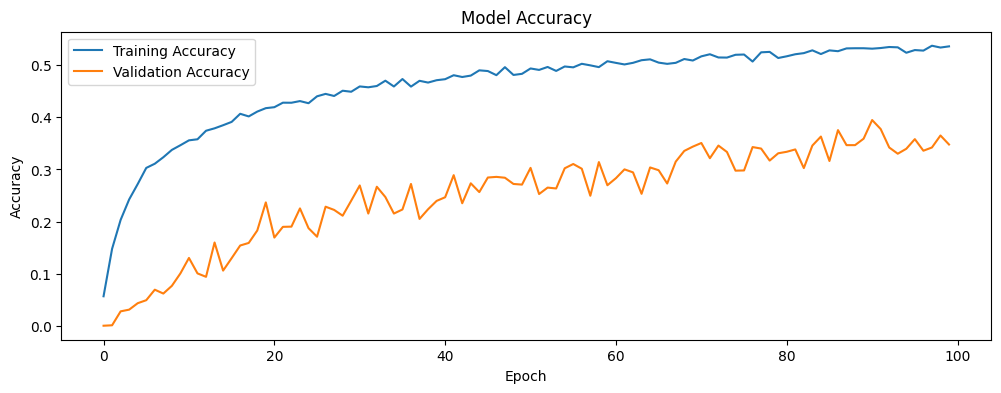


Classification Report:
               precision    recall  f1-score   support

     Abundant       0.59      0.99      0.74        67
       Active       0.60      0.79      0.68        67
        Adult       0.92      0.88      0.90        67
        Agile       0.51      0.88      0.65        67
     Alluring       0.92      0.67      0.78        67
      Amiable       0.23      0.51      0.32        67
      Amusing       0.73      0.85      0.79        67
      Aqueous       0.50      0.88      0.64        66
 Aristocratic       0.73      1.00      0.84        67
     Aromatic       0.80      0.97      0.88        67
     Artistic       0.76      1.00      0.86        65
Authoritative       0.66      0.91      0.77        67
       Bitter       0.52      0.91      0.66        67
      Bitterl       0.48      1.00      0.65        63
         Bold       0.75      0.75      0.75        67
       Bright       0.63      0.46      0.53        67
    Brilliant       0.72      0.79      

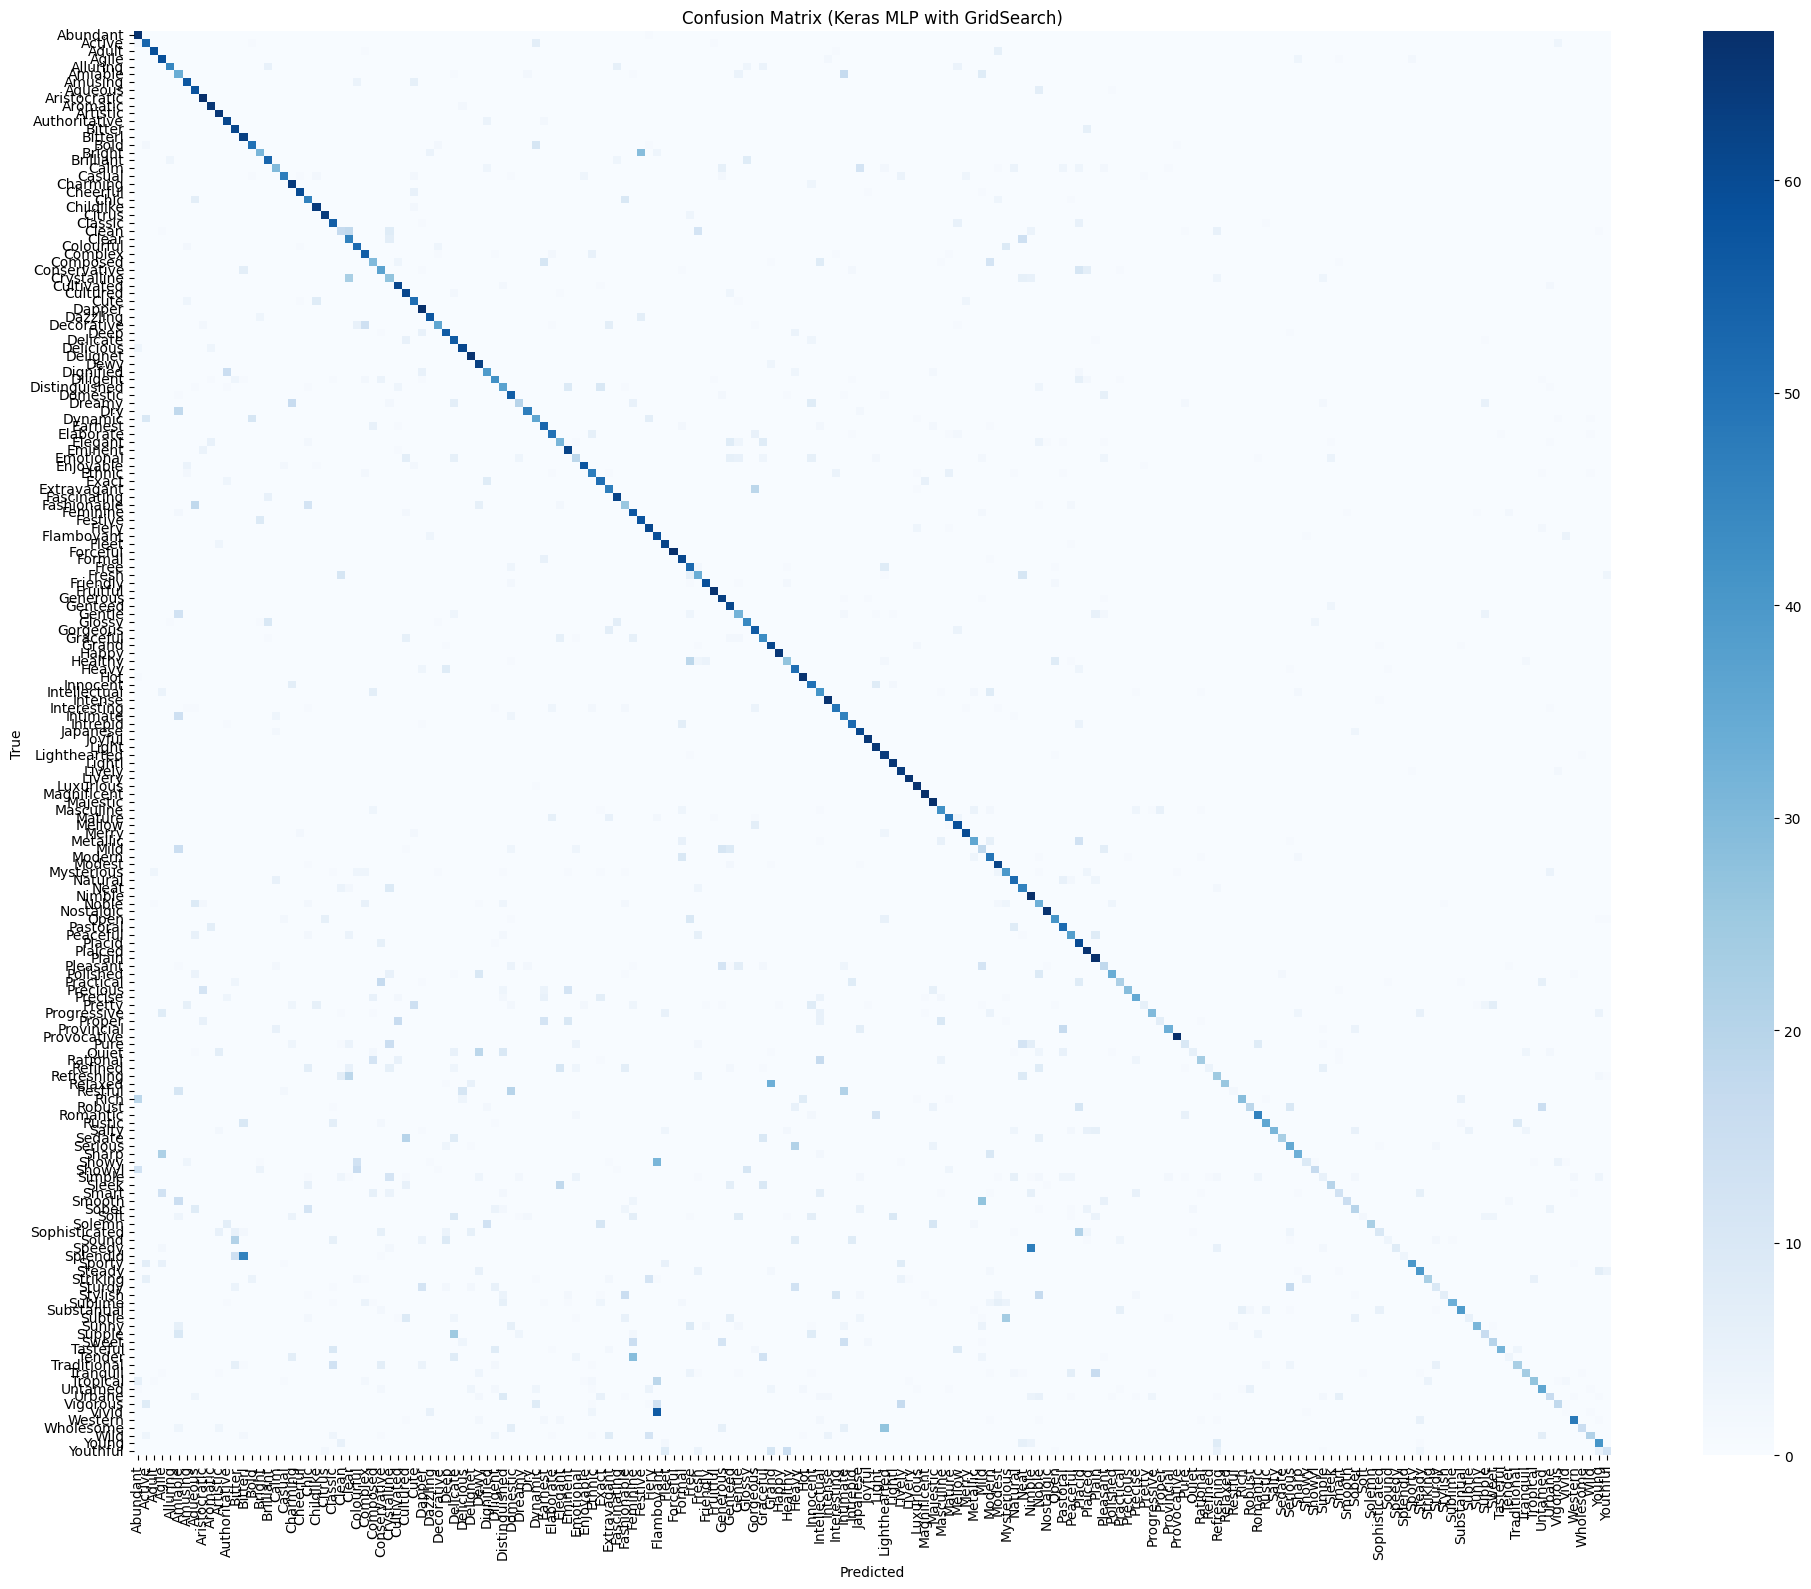

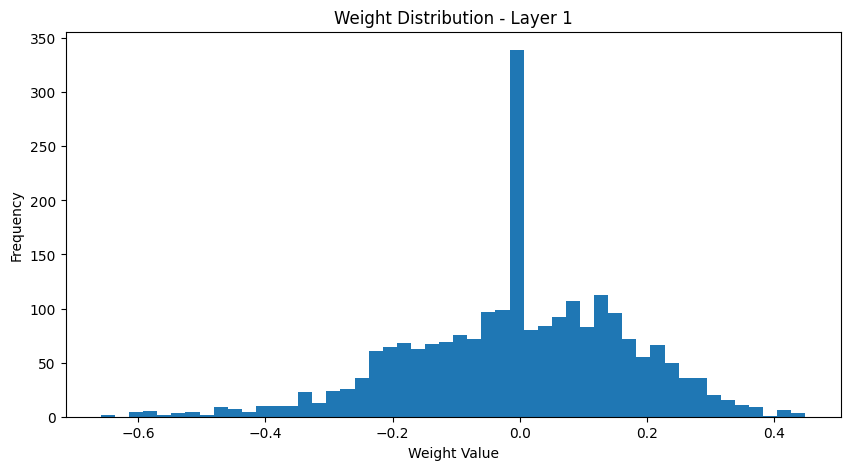

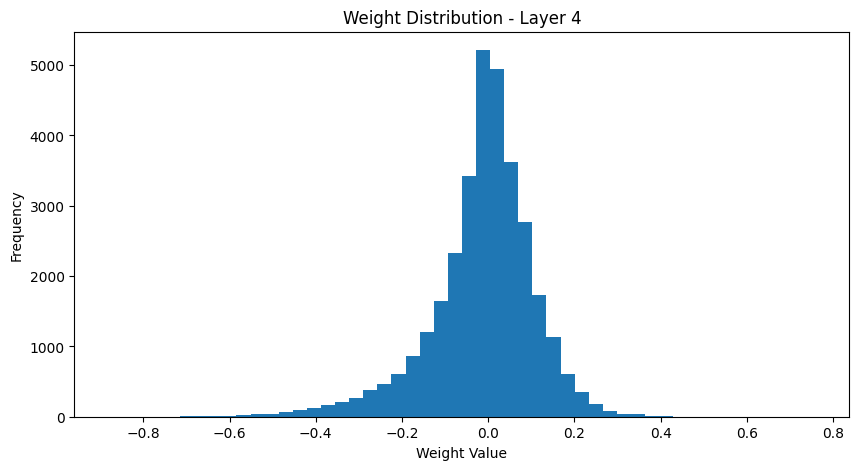

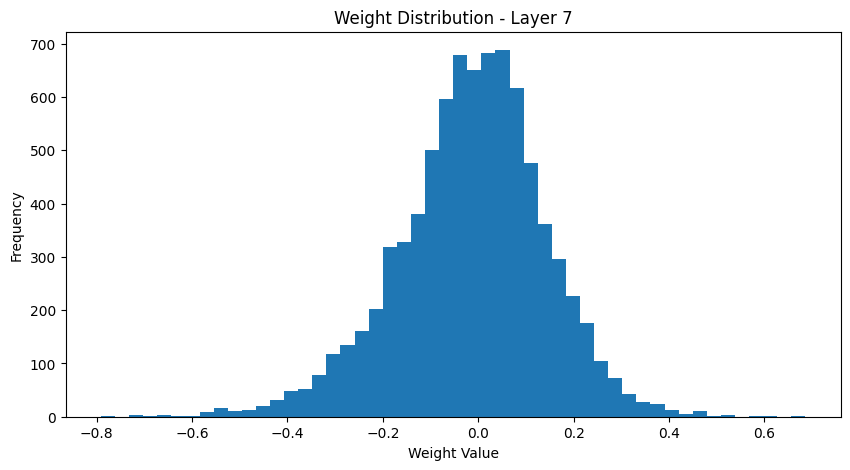

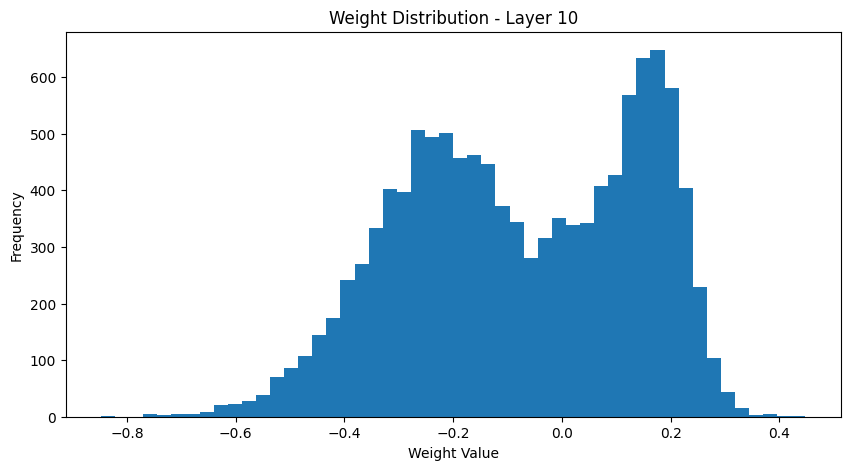

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Test Set Evaluation:
Test Accuracy: 0.7534
Test F1-score: 0.7353
Test Precision: 0.7907
Test Recall: 0.7534

Total number of parameters: 57334


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools

# Load and preprocess the data
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(class_weights))

# Define the model creation function
def create_model(learning_rate=0.001, dropout_rate=0.3, l2_reg=0.001):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X.shape[1],), kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(y_categorical.shape[1], activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the parameter grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'dropout_rate': [0.3, 0.4, 0.5],
    'l2_reg': [0.01, 0.001, 0.0001]
}

# Outer cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Inner cross-validation
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Custom grid search function
def grid_search(X, y, param_grid, inner_cv):
    best_score = -np.inf
    best_params = None
    
    for params in itertools.product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))
        scores = []
        
        for train_idx, val_idx in inner_cv.split(X, y):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = create_model(**param_dict)
            model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, 
                      class_weight=class_weight_dict, validation_data=(X_val, y_val))
            
            val_score = model.evaluate(X_val, y_val, verbose=0)[1]
            scores.append(val_score)
        
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_params = param_dict
    
    return best_params, best_score

# Nested cross-validation
cv_scores = []
all_y_true = []
all_y_pred = []

start_time = time.time()

for fold, (train_index, test_index) in enumerate(outer_cv.split(X, y_encoded), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]
    
    # Perform grid search on the training data
    best_params, _ = grid_search(X_train, y_train, param_grid, inner_cv)
    
    # Train the best model
    best_model = create_model(**best_params)
    best_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, 
                   class_weight=class_weight_dict, validation_split=0.2)
    
    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    cv_scores.append(accuracy)
    all_y_true.extend(y_true_classes)
    all_y_pred.extend(y_pred_classes)
    
    print(f"Fold {fold}")
    print(f"Best parameters: {best_params}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print()

end_time = time.time()

# Print the cross-validation results
print("\nKeras MLP with GridSearch Results:")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

# Calculate overall F1-score, precision, and recall
f1 = f1_score(all_y_true, all_y_pred, average='weighted')
precision = precision_score(all_y_true, all_y_pred, average='weighted')
recall = recall_score(all_y_true, all_y_pred, average='weighted')
print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print(f"Training time: {end_time - start_time:.2f} seconds")

# Train the final model using the best parameters
final_model = create_model(**best_params)

# Fit the final model on the entire dataset
history = final_model.fit(X, y_categorical, epochs=100, batch_size=32, 
                          validation_split=0.2, class_weight=class_weight_dict, verbose=0)

# Plot learning curves
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Generate classification report
class_names = label_encoder.classes_
print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(20, 16))
cm = confusion_matrix(all_y_true, all_y_pred)
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Keras MLP with GridSearch)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Plot weight distributions
def plot_weight_distribution(model):
    for i, layer in enumerate(model.layers):
        if isinstance(layer, Dense):
            weights = layer.get_weights()[0]
            plt.figure(figsize=(10, 5))
            plt.hist(weights.flatten(), bins=50)
            plt.title(f'Weight Distribution - Layer {i+1}')
            plt.xlabel('Weight Value')
            plt.ylabel('Frequency')
            plt.show()

plot_weight_distribution(final_model)

# Evaluate on a separate test set
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42)
final_model.fit(X_train, y_train, epochs=100, batch_size=32, class_weight=class_weight_dict, verbose=0)
y_pred = final_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nTest Set Evaluation:")
print(f"Test Accuracy: {accuracy_score(y_true_classes, y_pred_classes):.4f}")
print(f"Test F1-score: {f1_score(y_true_classes, y_pred_classes, average='weighted'):.4f}")
print(f"Test Precision: {precision_score(y_true_classes, y_pred_classes, average='weighted'):.4f}")
print(f"Test Recall: {recall_score(y_true_classes, y_pred_classes, average='weighted'):.4f}")

# Print model complexity
total_params = final_model.count_params()
print(f"\nTotal number of parameters: {total_params}")